In [1]:
import sys
import os
import re

import cProfile
import pstats
import io
from memory_profiler import profile

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [2]:
import matplotlib.pyplot as plt
import plotnine as p9

In [3]:
import matplotlib

%matplotlib inline
matplotlib.rcParams["figure.dpi"] = 150  # 150 dpi resolution
matplotlib.rcParams["image.cmap"] = "Spectral_r"  # preferred color map
matplotlib.rcParams["figure.figsize"] = [6, 6]  # Square
# no bounding boxes or axis:
matplotlib.rcParams["axes.spines.bottom"] = "on"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "on"
matplotlib.rcParams["axes.spines.right"] = "off"
# use Arial
matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["font.family"] = "sans-serif"
p9.options.figure_size = (15, 5)

In [4]:
ds_names = ["tcell", "ips", "cd34", "mgast"]
ad_base_dir = "/fh/fast/setty_m/user/dotto/CellDensities/data/subsamples/hierarchical"
bench_base_dir = "/fh/fast/setty_m/user/dotto/CellDensities/data/benchmarks/subsamples"

run_modes = {
    "hierarchical": ("hierarchical", 36, True, False),
    "hierarchical_noNy": ("hierarchical", 36, False, False),
    "hierarchical_noNy_fractal": ("hierarchical", 36, False, True),
    "hierarchical_1core": ("hierarchical", 1, True, False),
    "hierarchical_noNy_1core": ("hierarchical", 1, False, False),
}
run_modes_desc = ("subsampling", "cores", "nystrom", "fractal_d")

calls = {
    "1 pca": "(make_pca)",
    #'2 diffusion_map':'(make_diffusion_components)',
    "2 diffusion_map": "(run_diffusion_maps)",  # only the palantir function
    "3 nn-distances": "(_compute_nn_distances)",
    "4 k-means": "(_compute_landmarks)",
    #'make-cov-function':'(_compute_cov_func)',
    #'make-loss-function':'(_compute_loss_func)',
    #'find-mu':'(_compute_mu)',
    #'find-ls':'(_compute_ls)',
    #"5 find-d": "(_compute_d)",
    "5 cov-decomp": "(_compute_L)",
    "6 initial-value": "(_compute_initial_value)",
    "7 optimization": "(run_inference)",
    #'transform-density':'(_set_log_density_x)',
    "8 make-predictive-function": "(_set_log_density_func)",
}
sub_calls = set(calls.keys()) - {"8 make-predictive-function"}

In [5]:
def get_cumtime(ps, s, call):
    ps.print_stats(call)
    ss = s.getvalue()
    # ncalls, tottime, percall, cumtime, percall, call = ss.splitlines()[-3].split()
    stats = ss.splitlines()[-3].split()
    if len(stats) < 6:
        return 0.0
    return float(stats[3])


def get_cumtimes(fl, calls):
    with io.StringIO() as s:
        ps = pstats.Stats(fl, stream=s)
        cumtimes = [get_cumtime(ps, s, call) for call in calls]
    return cumtimes


def get_stats(fl, call):
    with io.StringIO() as s:
        ps = pstats.Stats(fl, stream=s)
        ps.sort_stats(pstats.SortKey.CUMULATIVE).print_stats(call)
        vals = s.getvalue()
        print(vals)
        # return vals

In [6]:
pattern = re.compile("sub_([0-9]*).h5ad")
ds_lines = list()
other_lines = list()
densities_lines = list()
run_modes_s = {
    mode: pd.DataFrame(
        dict(zip(run_modes_desc, desc)),
        index=[
            0,
        ],
    )
    for mode, desc in run_modes.items()
}


def numerify(col):
    try:
        return pd.to_numeric(col)
    except (ValueError, TypeError):
        return col


for ds_name in ds_names:
    ad_dir = f"{ad_base_dir}/{ds_name}/"
    fl_list = os.listdir(ad_dir)
    for fl in tqdm(sorted(fl_list), total=len(fl_list), desc=ds_name):
        if not (match := pattern.match(fl)):
            continue
        idstr = match.groups()[0]
        # densities_lines.append([ds_name, ad.n_obs, ad.obs['log_density']])

        for mode, b_stats in run_modes_s.items():
            a_stats = pd.DataFrame(
                {"id_str": idstr, "dataset": ds_name, "mode": mode},
                index=[
                    0,
                ],
            )
            try:
                c_stats = pd.read_csv(
                    f"{bench_base_dir}/{mode}/{ds_name}/estimator_stats_{idstr}.csv",
                    index_col=0,
                ).T.reset_index()
            except FileNotFoundError:
                print(f"Not found: {ds_name} - {mode} - {idstr}")
                continue
            profile_file = (
                f"{bench_base_dir}/{mode}/{ds_name}/profile_time_dump_{idstr}"
            )
            d_stats = pd.DataFrame(
                dict(zip(calls.keys(), get_cumtimes(profile_file, calls.values()))),
                index=[
                    0,
                ],
            )
            ds_lines.append(pd.concat([a_stats, b_stats, c_stats, d_stats], axis=1))
first_stats = pd.concat(ds_lines, axis=0).apply(numerify, axis=0)
first_stats["fractal"] = first_stats["mode"].str.contains("fractal")
first_stats["desc"] = (
    first_stats["dataset"]
    + " "
    + np.where(first_stats["nystrom"], "Nystrom", "Cholesky")
    + " "
    + np.where(first_stats["cores"] == 1, "single core", "multi core")
    + np.where(first_stats["mode"].str.contains("fractal"), " fractal", "")
).astype("category")

tcell:   0%|          | 0/42 [00:00<?, ?it/s]

ips:   0%|          | 0/74 [00:00<?, ?it/s]

cd34:   0%|          | 0/40 [00:00<?, ?it/s]

mgast:   0%|          | 0/60 [00:00<?, ?it/s]

In [7]:
stats = first_stats.copy()
# stats['n_obs_'] = stats['n_obs'].astype(float)
# stats['final_rank_'] = stats['final_rank'].astype(float)
stats["Cores"] = stats["cores"].astype("category")
stats["total_time"] = stats.loc[:, calls.keys()].sum(axis=1)
stats["total_time_base"] = stats.loc[:, list(sub_calls)].sum(axis=1)

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_stack requires non-overlapping x intervals


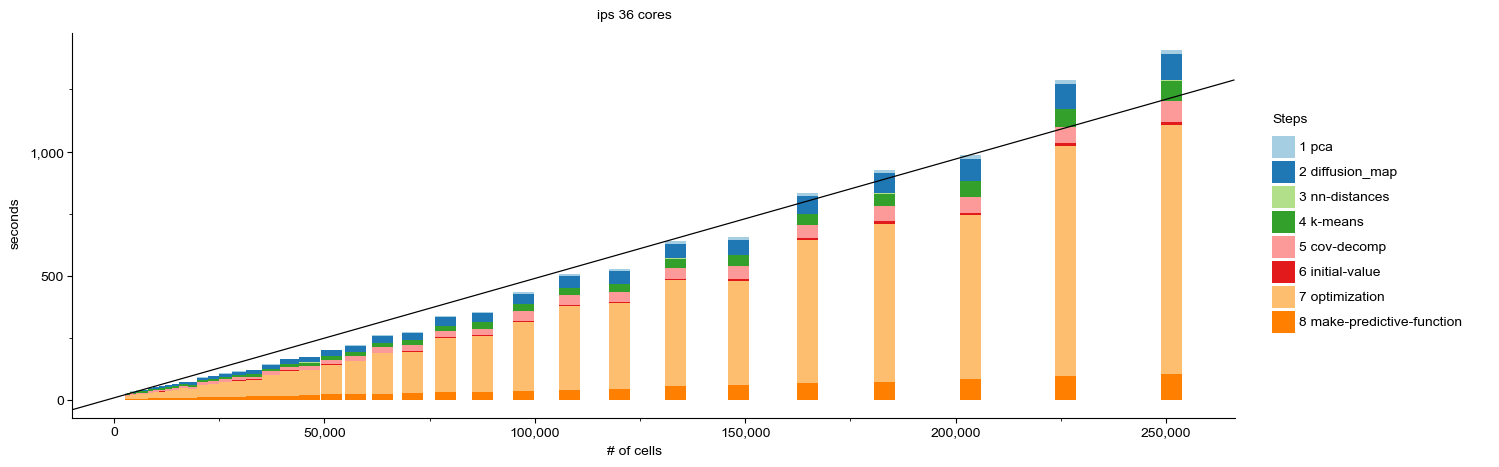

In [8]:
ds_name = "ips"
method = "hierarchical_noNy"

titel = f"{ds_name} 36 cores"
idx = (stats["dataset"] == ds_name) & (stats["mode"] == method)
idx &= stats["n_obs"] >= 5000
sub_stats = stats.loc[
    idx,
    list(calls.keys())
    + [
        "n_obs",
    ],
].melt(id_vars="n_obs", value_name="seconds")
sub_stats["seconds"] = sub_stats["seconds"].astype(float)
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "seconds", fill="variable"))
    + p9.geom_bar(position="stack", stat="identity", width=5000)
    + p9.ggtitle(titel)
    + p9.xlab("# of cells")
    + p9.theme_matplotlib()
    + p9.geom_abline(intercept=10, slope=48e-4)
    + p9.labs(fill = "Steps")
    + p9.scales.scale_fill_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_stack requires non-overlapping x intervals


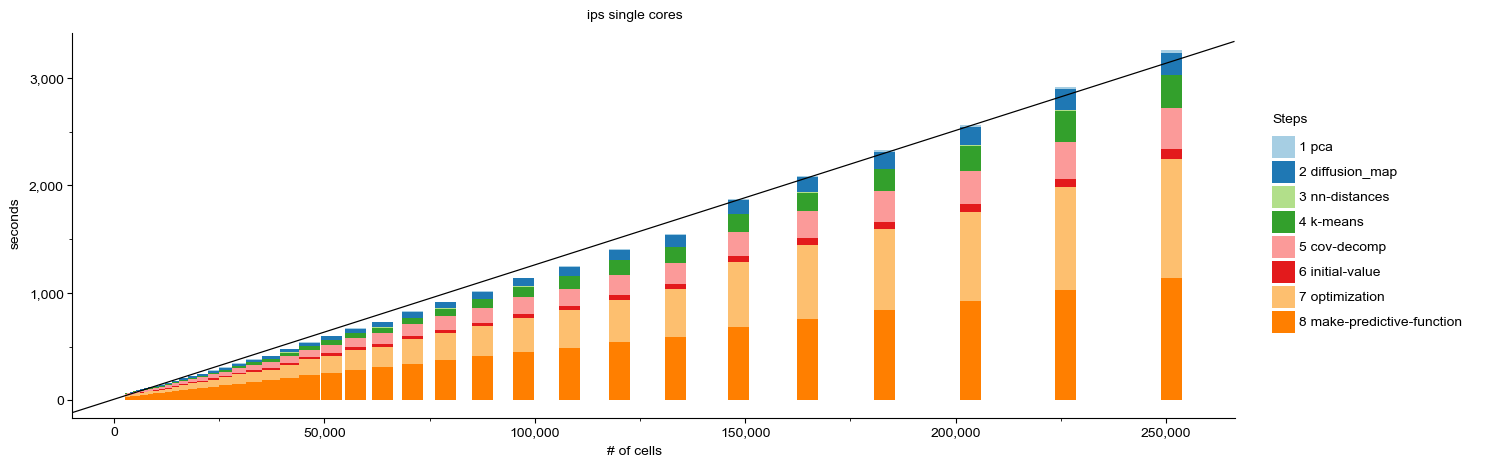

In [9]:
ds_name = "ips"
method = "hierarchical_noNy_1core"

titel = f"{ds_name} single cores"
idx = (stats["dataset"] == ds_name) & (stats["mode"] == method)
idx &= stats["n_obs"] >= 5000
sub_stats = stats.loc[
    idx,
    list(calls.keys())
    + [
        "n_obs",
    ],
].melt(id_vars="n_obs", value_name="seconds")
sub_stats["seconds"] = sub_stats["seconds"].astype(float)
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "seconds", fill="variable"))
    + p9.geom_bar(position="stack", stat="identity", width=5000)
    + p9.ggtitle(titel)
    + p9.xlab("# of cells")
    + p9.theme_matplotlib()
    + p9.geom_abline(intercept=10, slope=125e-4)
    + p9.labs(fill = "Steps")
    + p9.scales.scale_fill_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

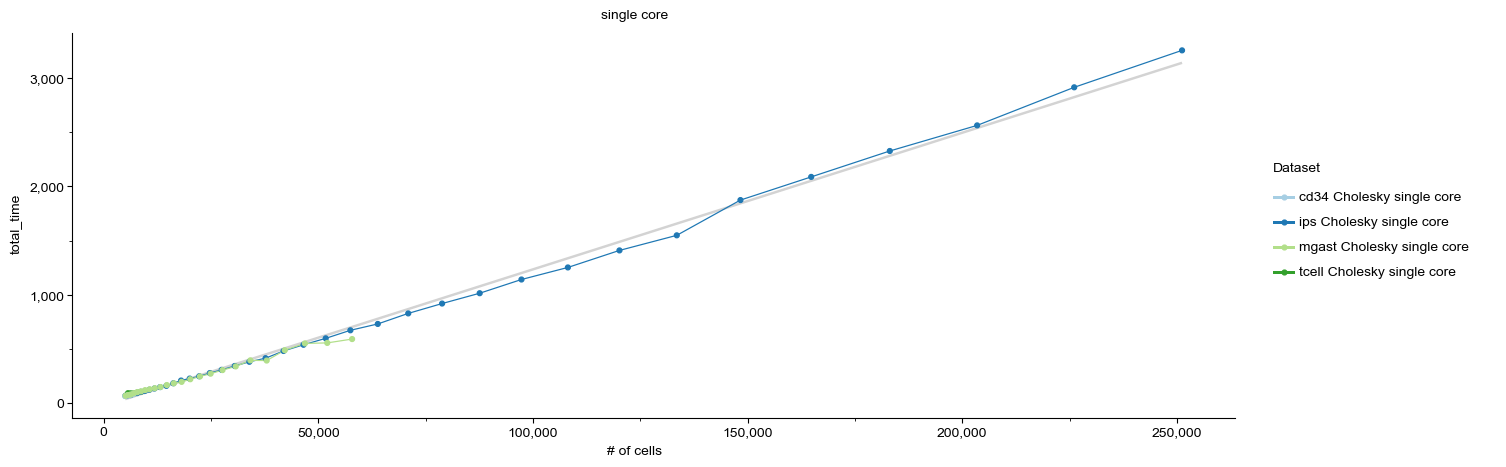

In [10]:
jump = 5000
idx = (stats["n_obs"] > jump) & ((stats["cores"] == 1)) & ((~stats["nystrom"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"single core")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

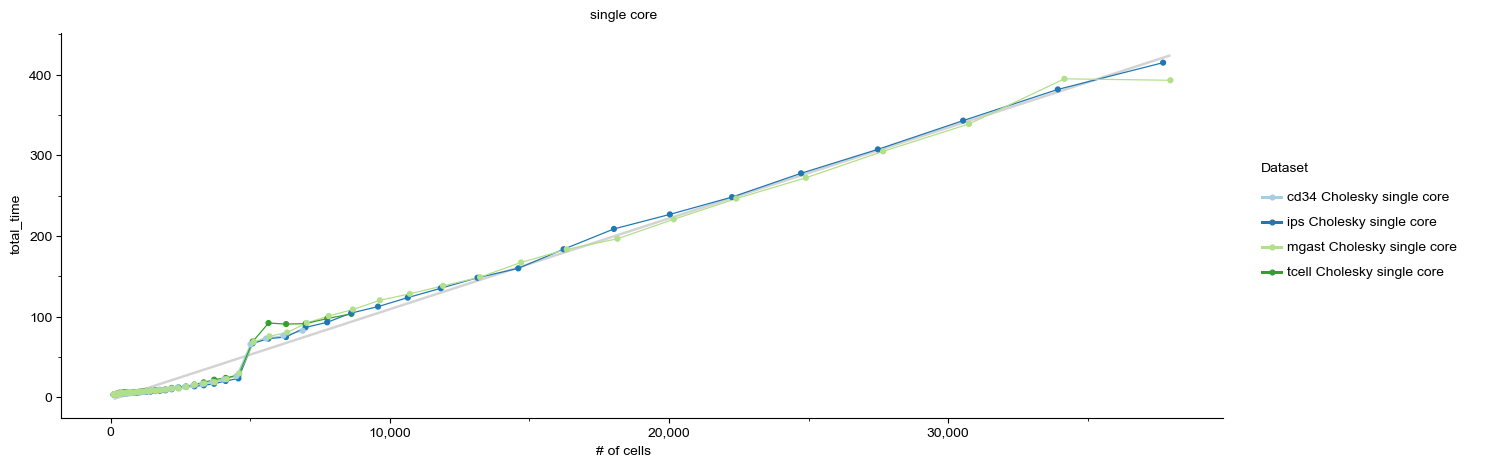

In [11]:
jump = 5000
idx = (stats["n_obs"] < 40000) & ((stats["cores"] == 1)) & ((~stats["nystrom"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"single core")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

In [12]:
extras = [
    pd.DataFrame({
        'desc':'z synthetic 6M',
        'cores':1,
        'n_obs':6_018_000,
        'dataset':'tcell_sim',
        'total_time': 32 + (50*60) + (11 * 60**2), #11h 50min 32s
        'fractal':False,
        'nystrom':False,
    }, index=[0]),
    pd.DataFrame({
        'desc':'z synthetic 10M',
        'cores':1,
        'n_obs':10_700_000,
        'dataset':'tcell_sim',
        'total_time': 55 + (9 * 60) + (7 * 60**2), #7h 9min 55s
        'fractal':False,
        'nystrom':False,
    }, index=[0]),
    stats,
]
gstats = pd.concat(extras, axis=0)

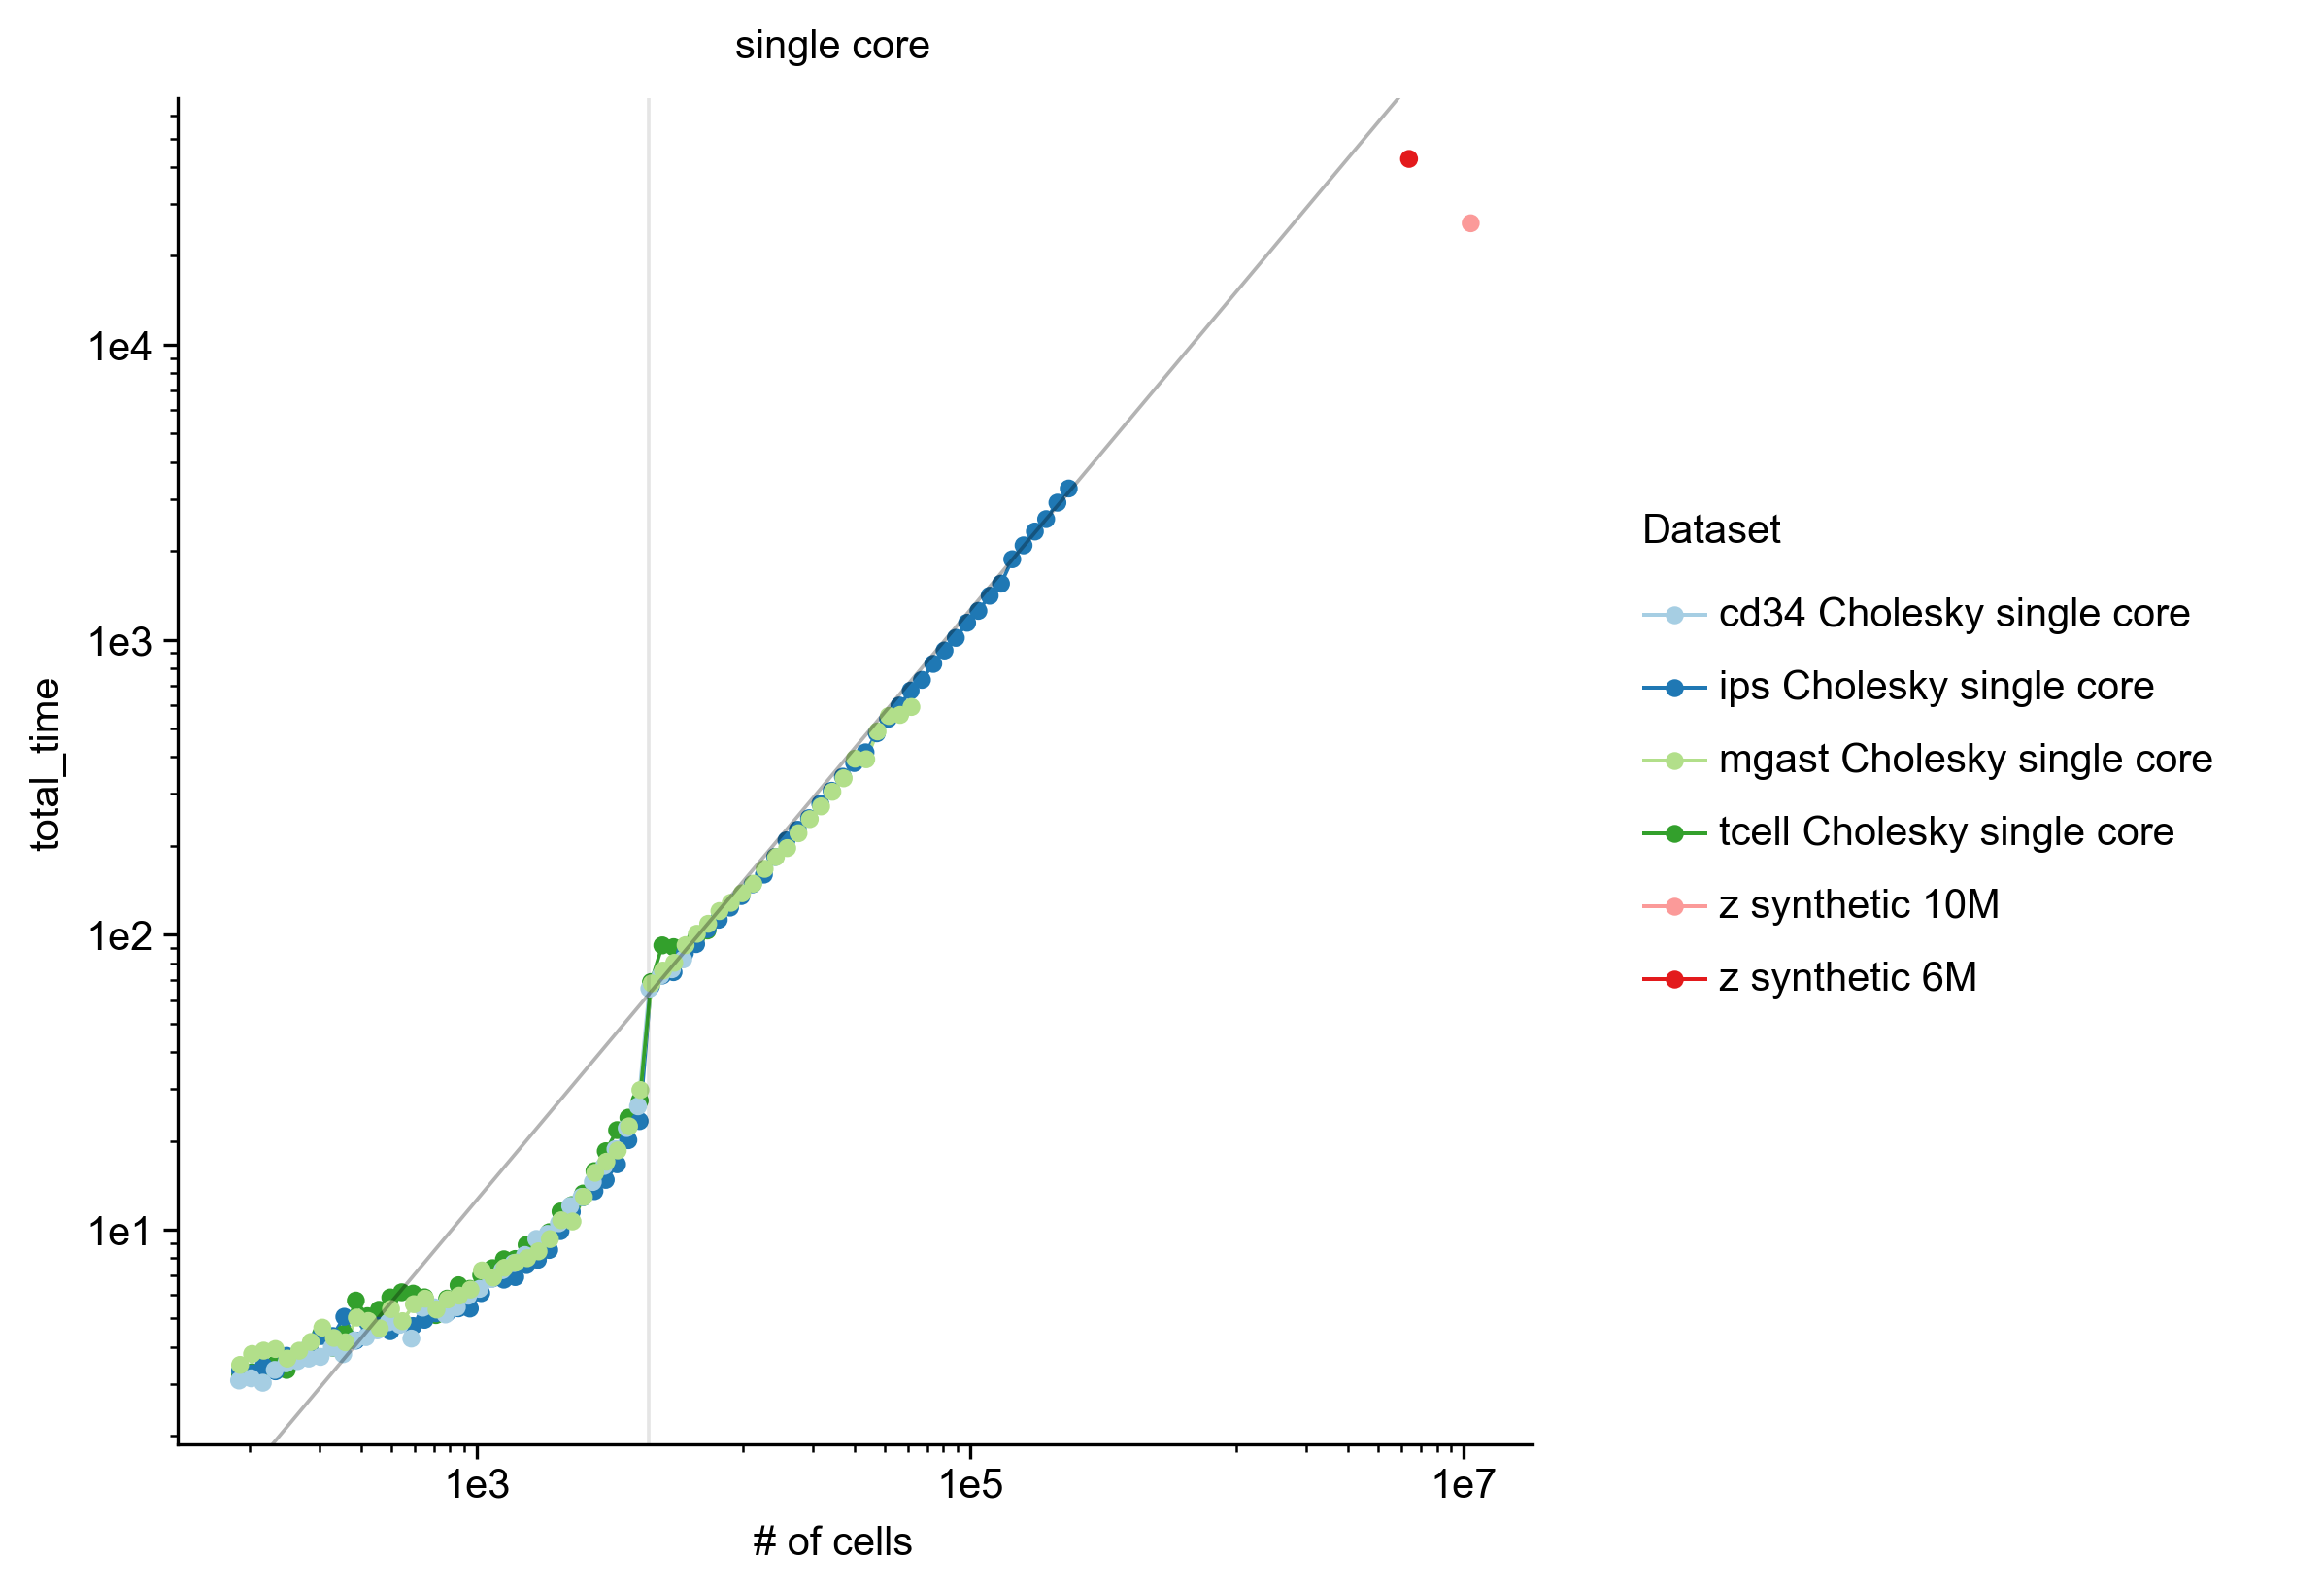

In [13]:
p9.options.figure_size = (6, 6)
p9.options.dpi = 300
idx = ((gstats["cores"] == 1)) & ((~gstats["nystrom"]))
sub_gstats = gstats.loc[idx, :].copy()
sub_gstats["desc"] = sub_gstats["desc"].astype("str")
pl = (
    p9.ggplot(sub_gstats, p9.aes("n_obs", "total_time", color="desc", group="desc"),)
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.geom_abline(slope=1, intercept=-1.9, alpha=.3)
    + p9.geom_vline(xintercept=5000, alpha=.1)
    + p9.ggtitle(f"single core")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_log10() + p9.scale_y_log10()
)
print(pl)

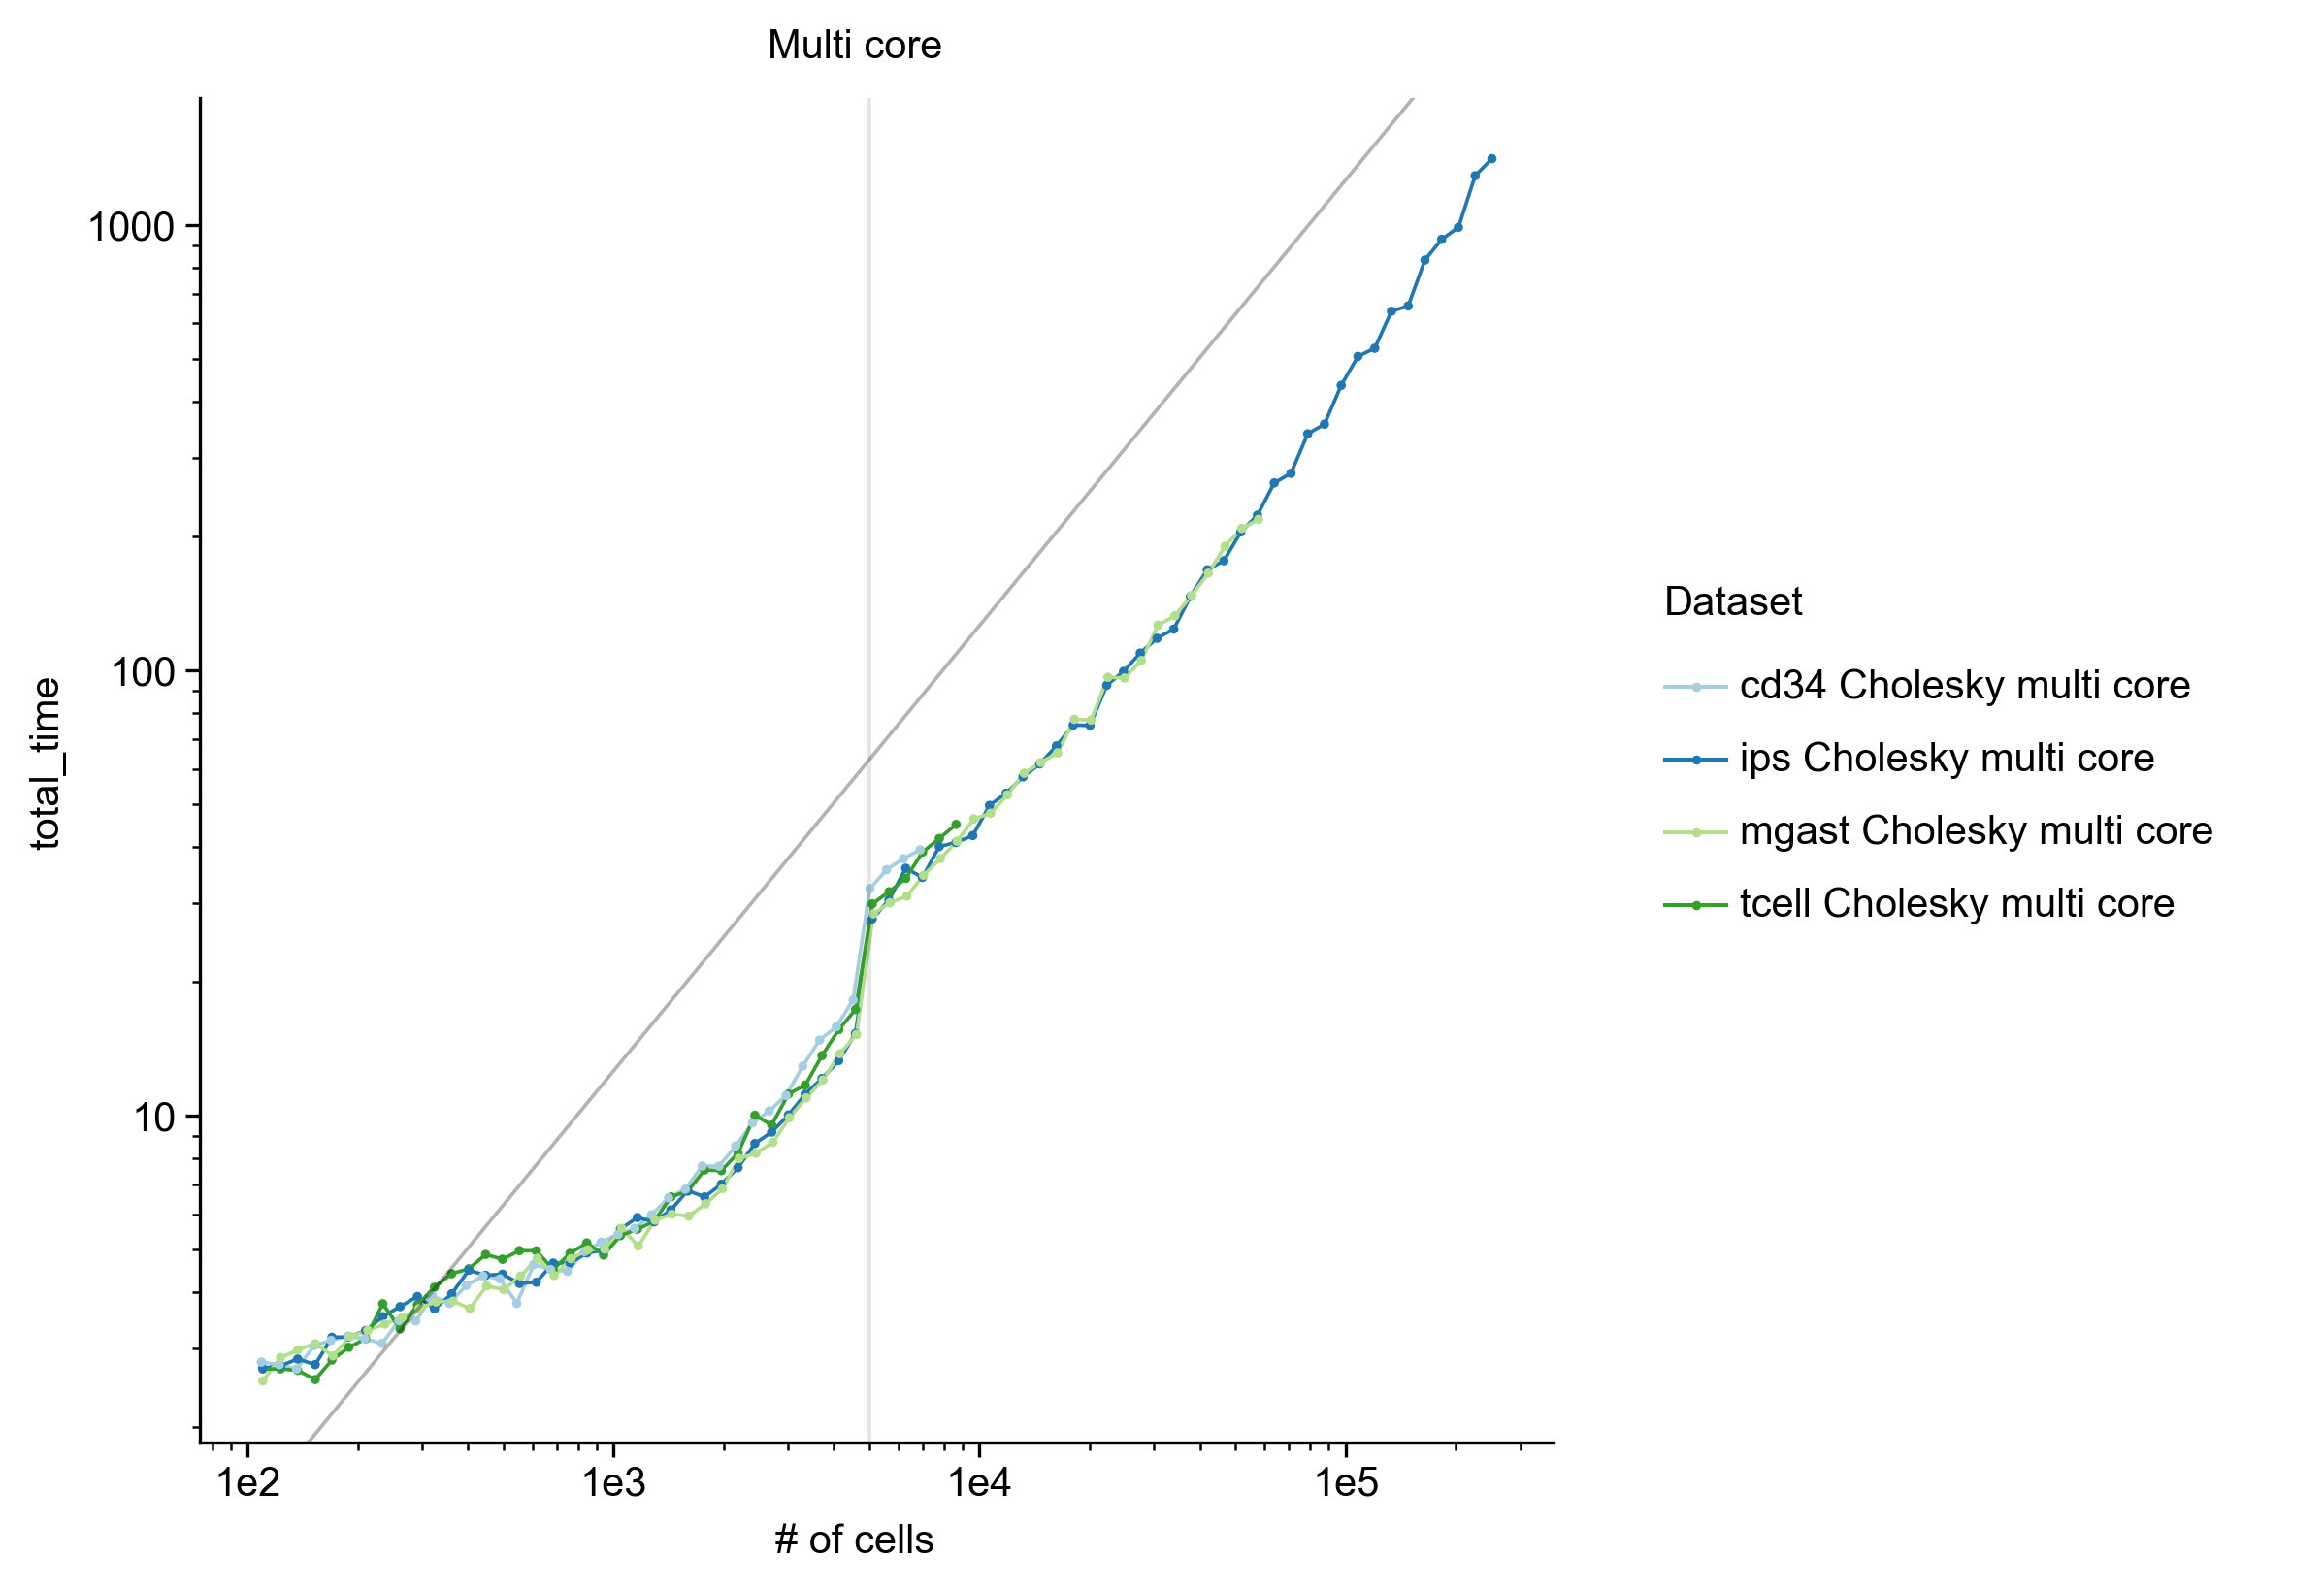

In [14]:
p9.options.figure_size = (6, 6)
p9.options.dpi = 300
idx = ((gstats["cores"] != 1)) & ((~gstats["nystrom"])) & ((~gstats["fractal"])) 
sub_gstats = gstats.loc[idx, :].copy()
sub_gstats["desc"] = sub_gstats["desc"].astype("str")
pl = (
    p9.ggplot(sub_gstats, p9.aes("n_obs", "total_time", color="desc", group="desc"),)
    + p9.geom_line()
    + p9.geom_point(size=.3)  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.geom_abline(slope=1, intercept=-1.9, alpha=.3)
    + p9.geom_vline(xintercept=5000, alpha=.1)
    + p9.ggtitle(f"Multi core")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_log10() + p9.scale_y_log10()
)
print(pl)

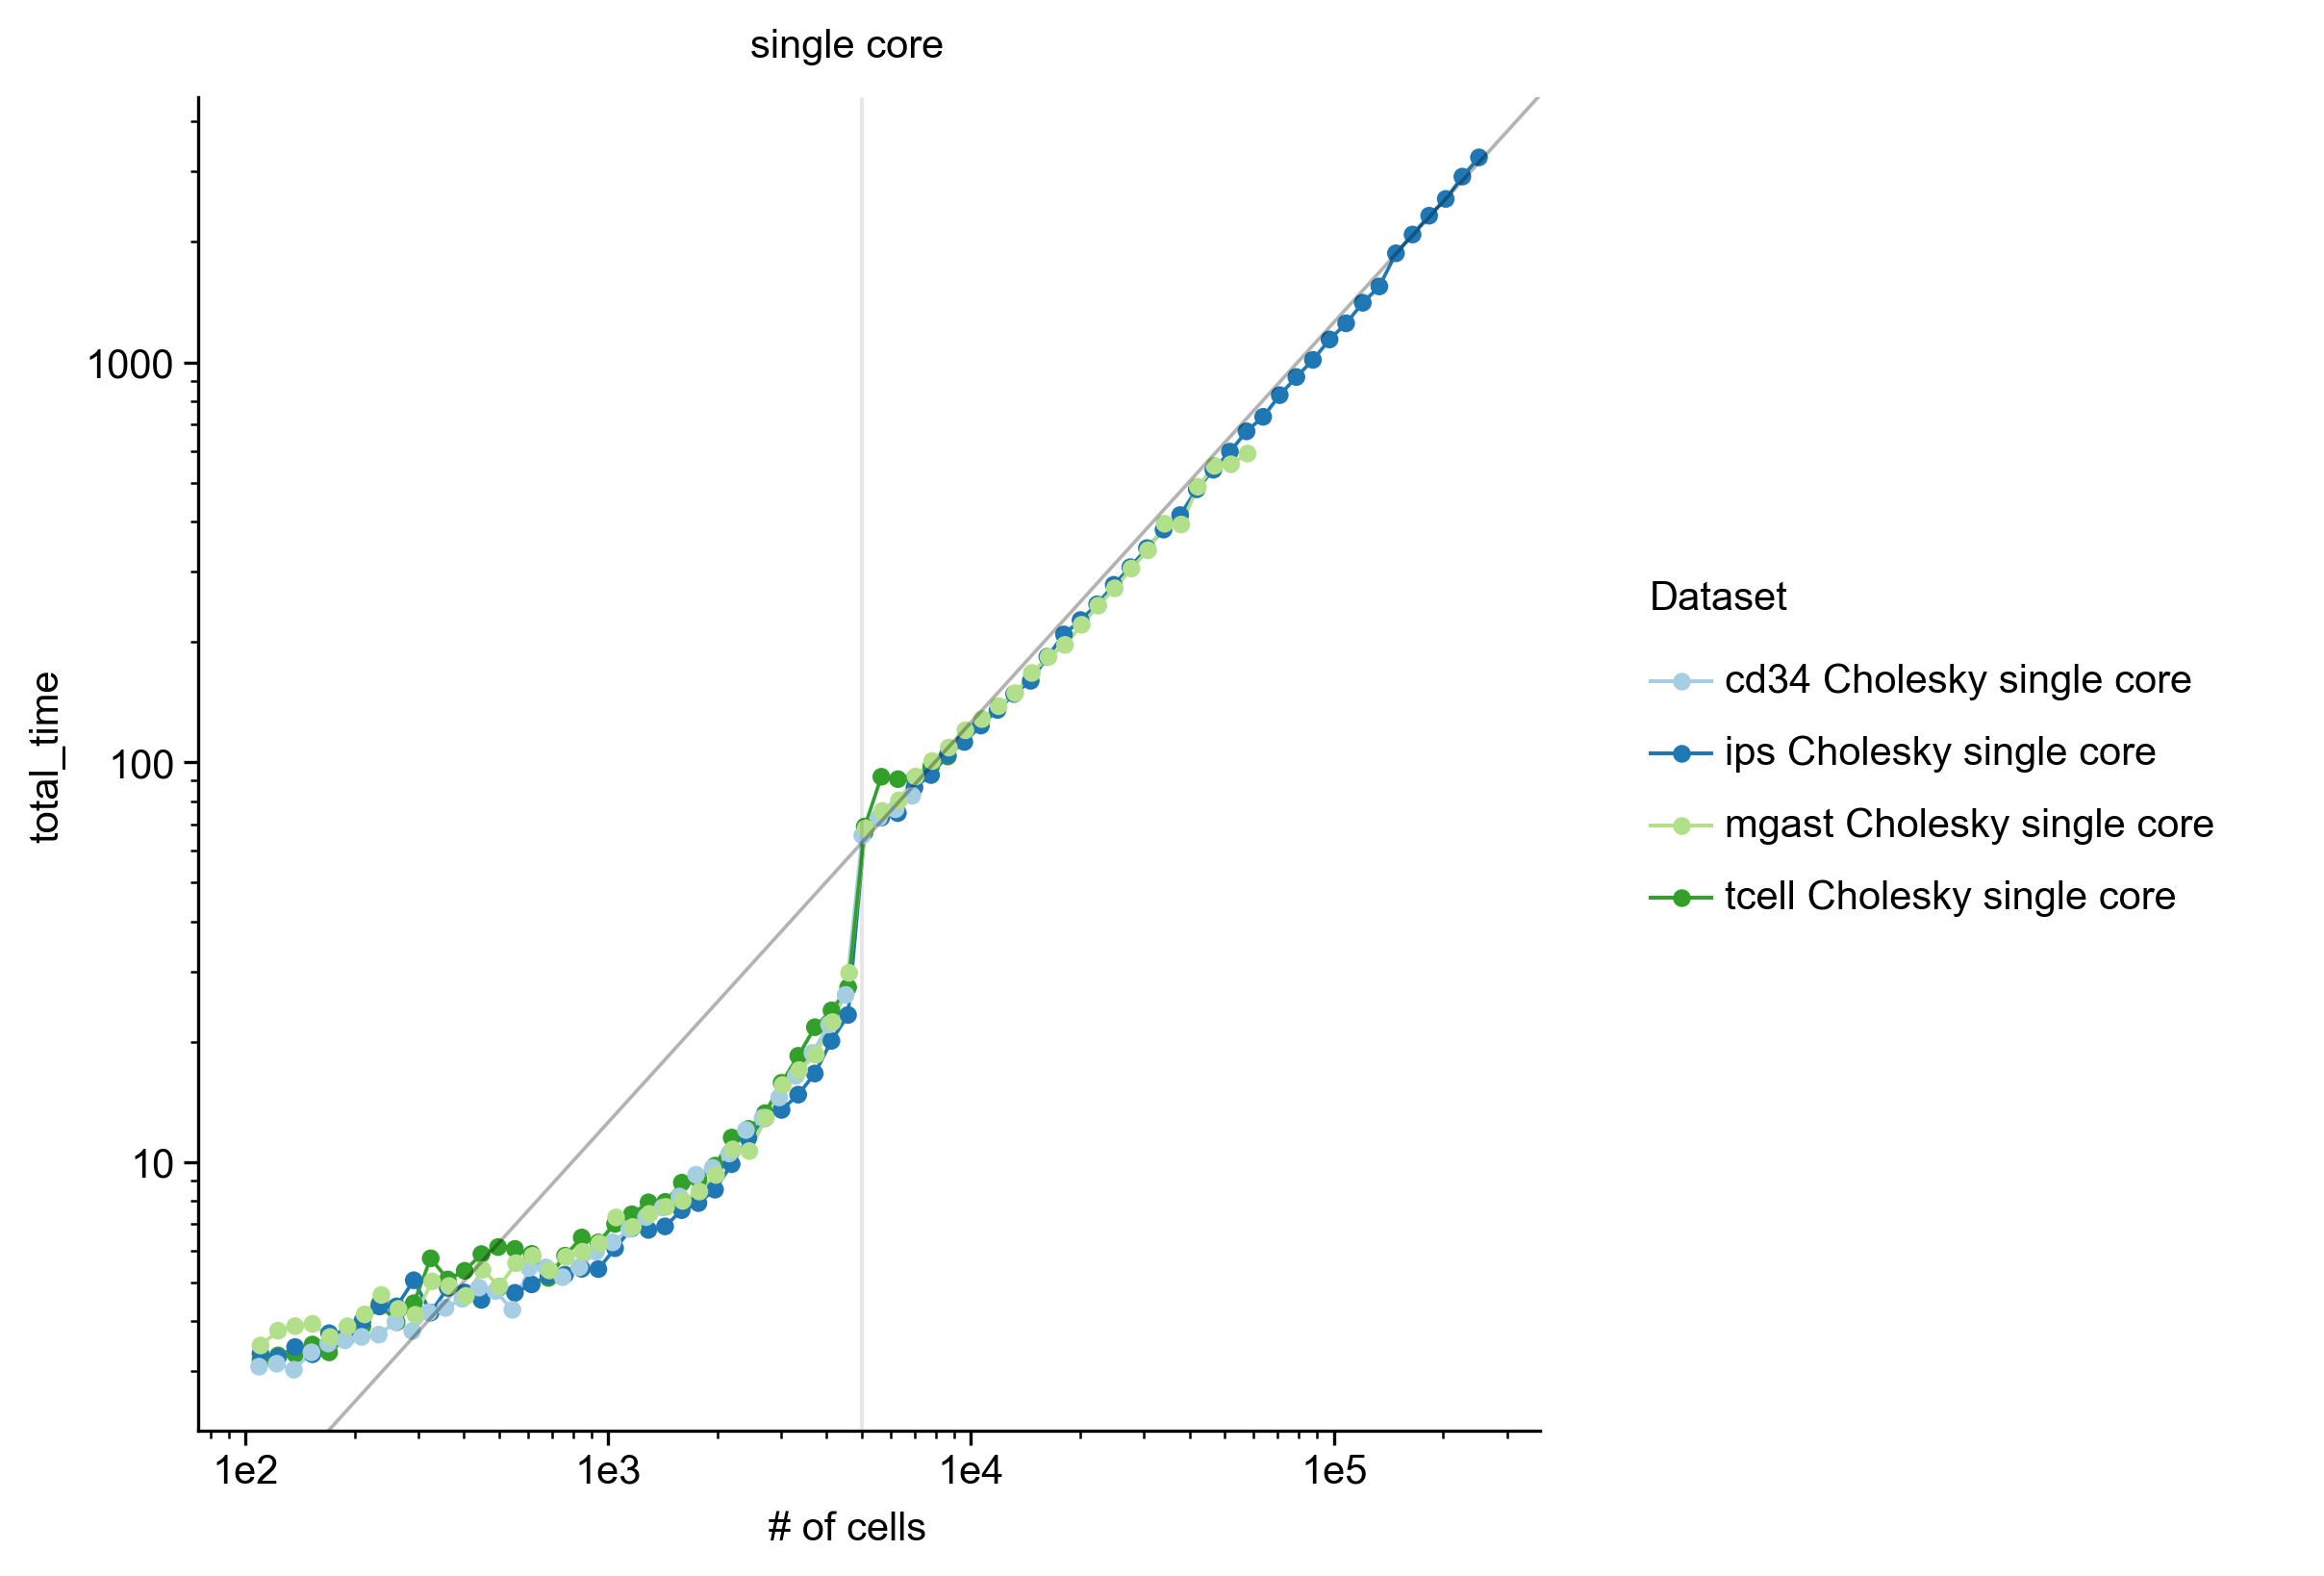

In [15]:
p9.options.figure_size = (6, 6)
p9.options.dpi = 300
idx = ((stats["cores"] == 1)) & ((~stats["nystrom"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time", color="desc", group="desc"),)
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.geom_abline(slope=1, intercept=-1.9, alpha=.3)
    + p9.geom_vline(xintercept=5000, alpha=.1)
    + p9.ggtitle(f"single core")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_log10() + p9.scale_y_log10()
)
print(pl)

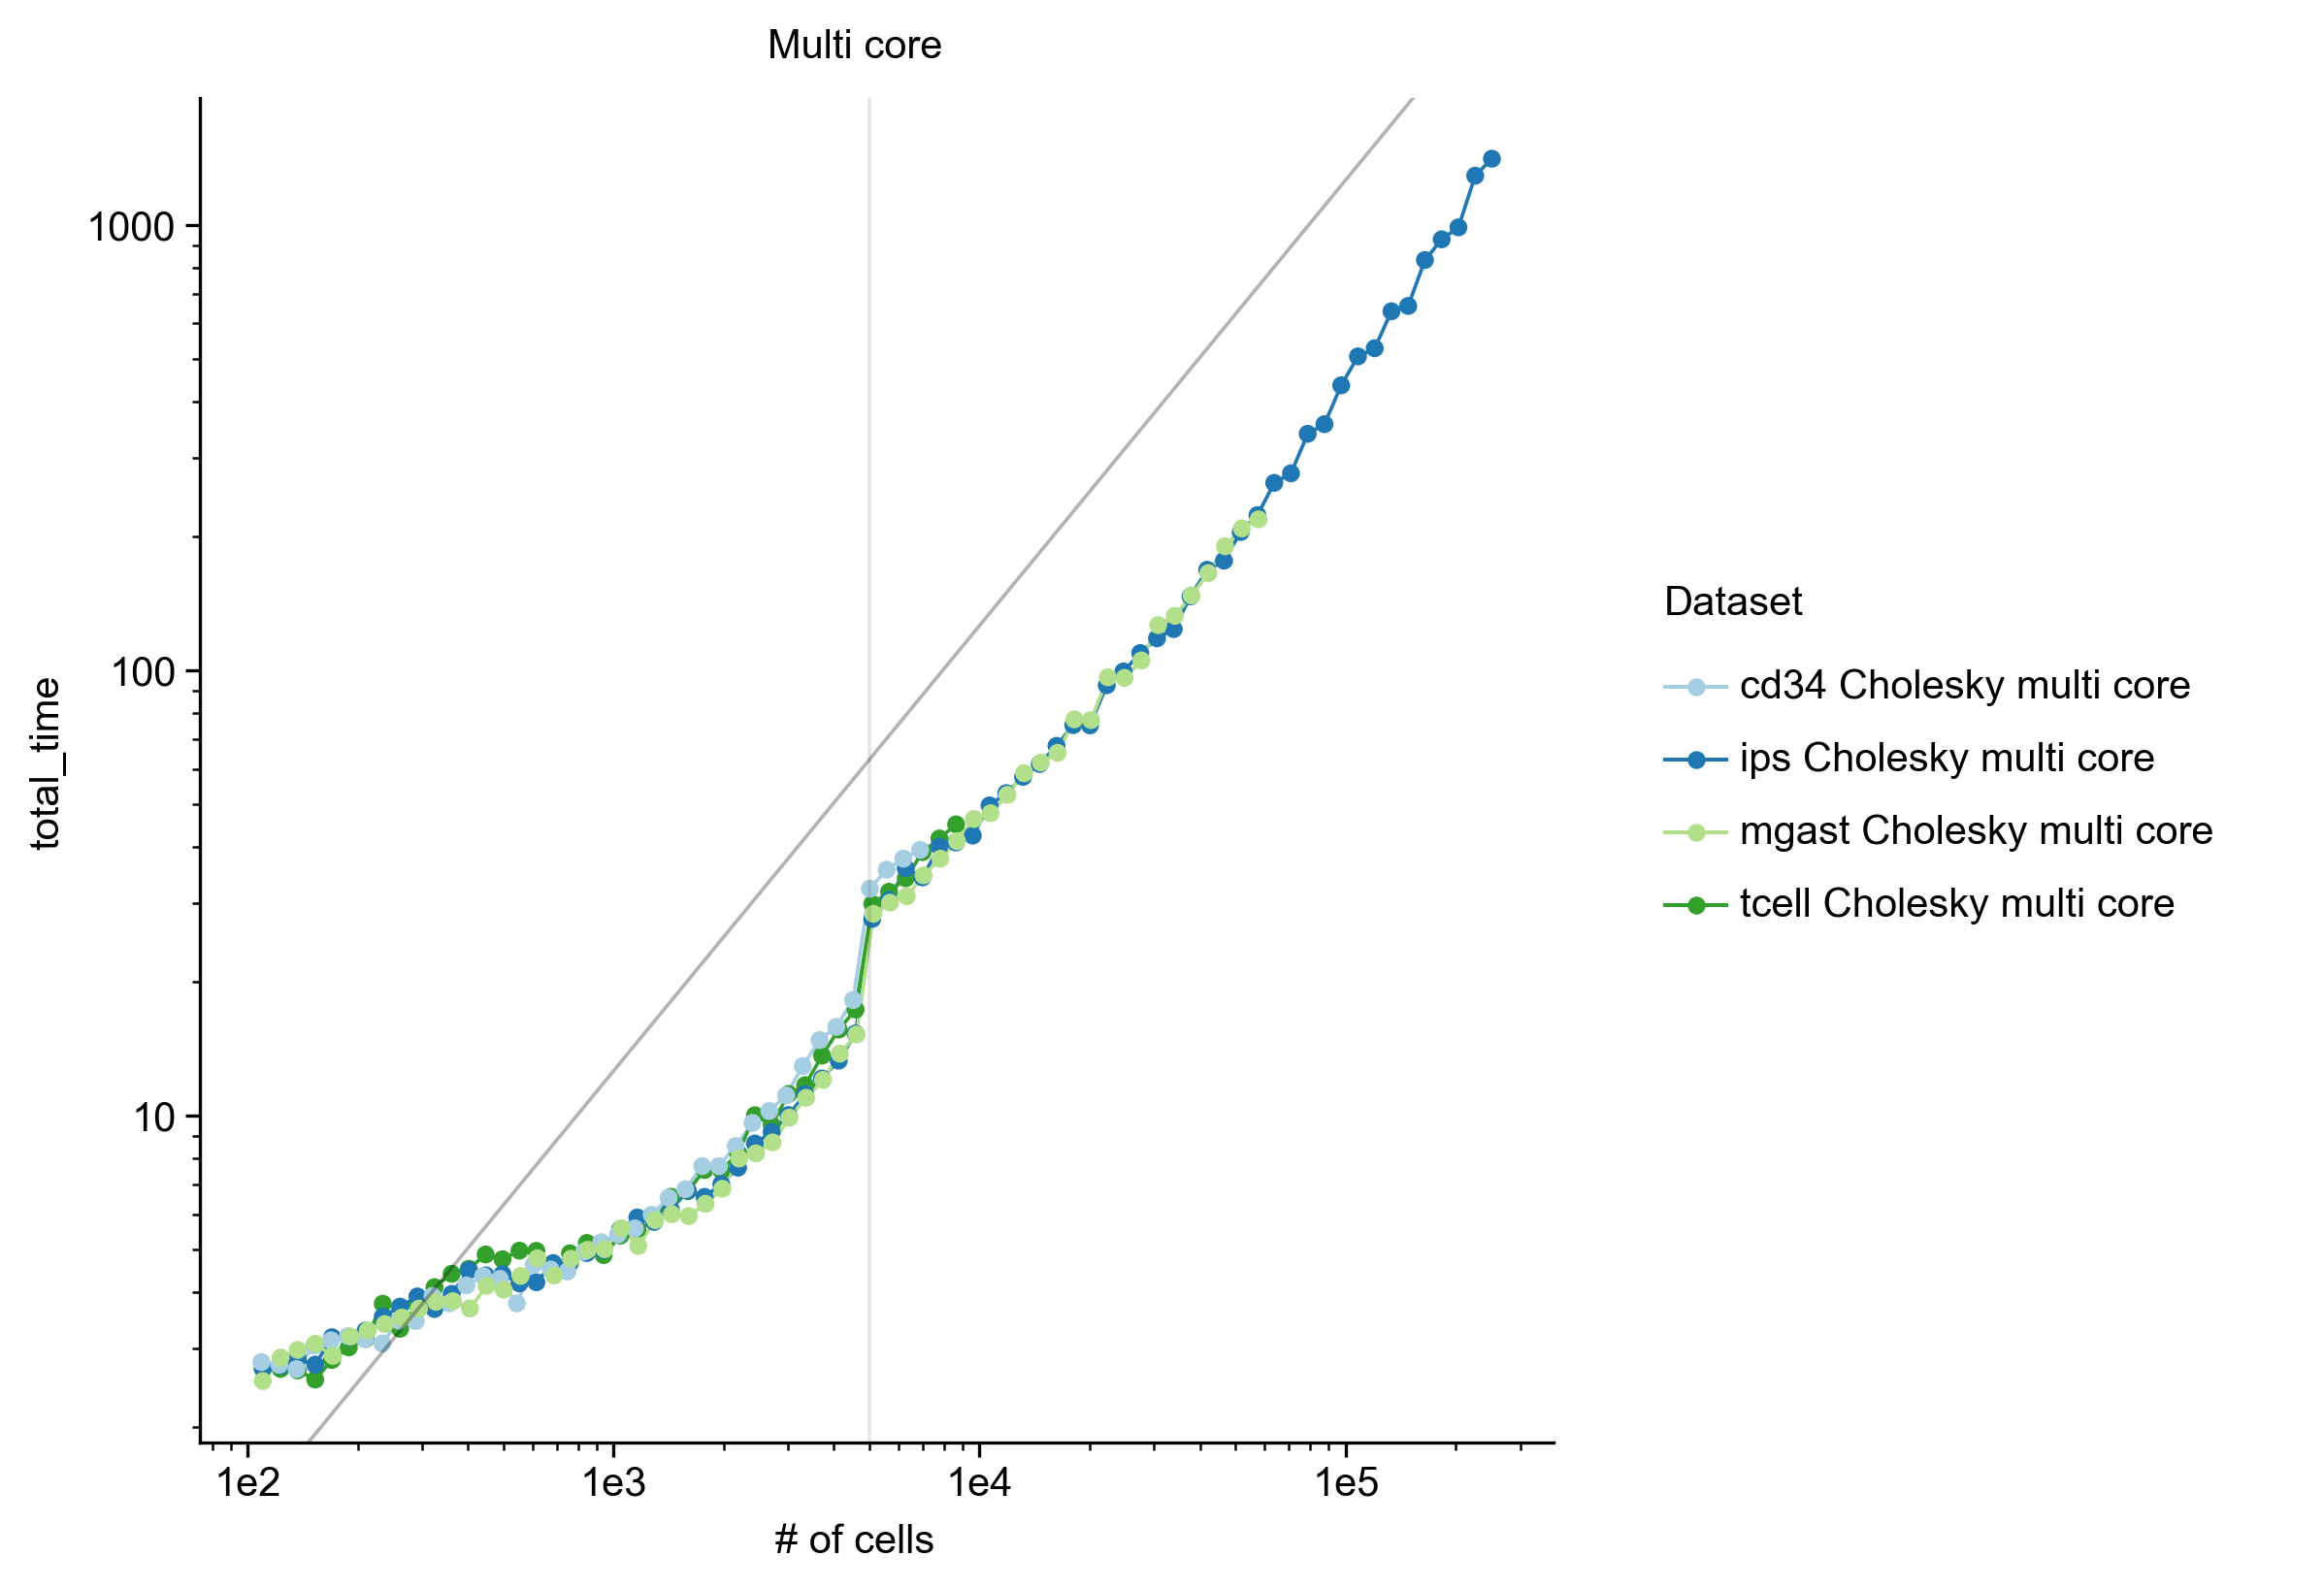

In [16]:
p9.options.figure_size = (6, 6)
p9.options.dpi = 300
idx = ((stats["cores"] != 1)) & ((~stats["nystrom"])) & ((~stats["fractal"])) 
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time", color="desc", group="desc"),)
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.geom_abline(slope=1, intercept=-1.9, alpha=.3)
    + p9.geom_vline(xintercept=5000, alpha=.1)
    + p9.ggtitle(f"Multi core")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_log10() + p9.scale_y_log10()
)
print(pl)

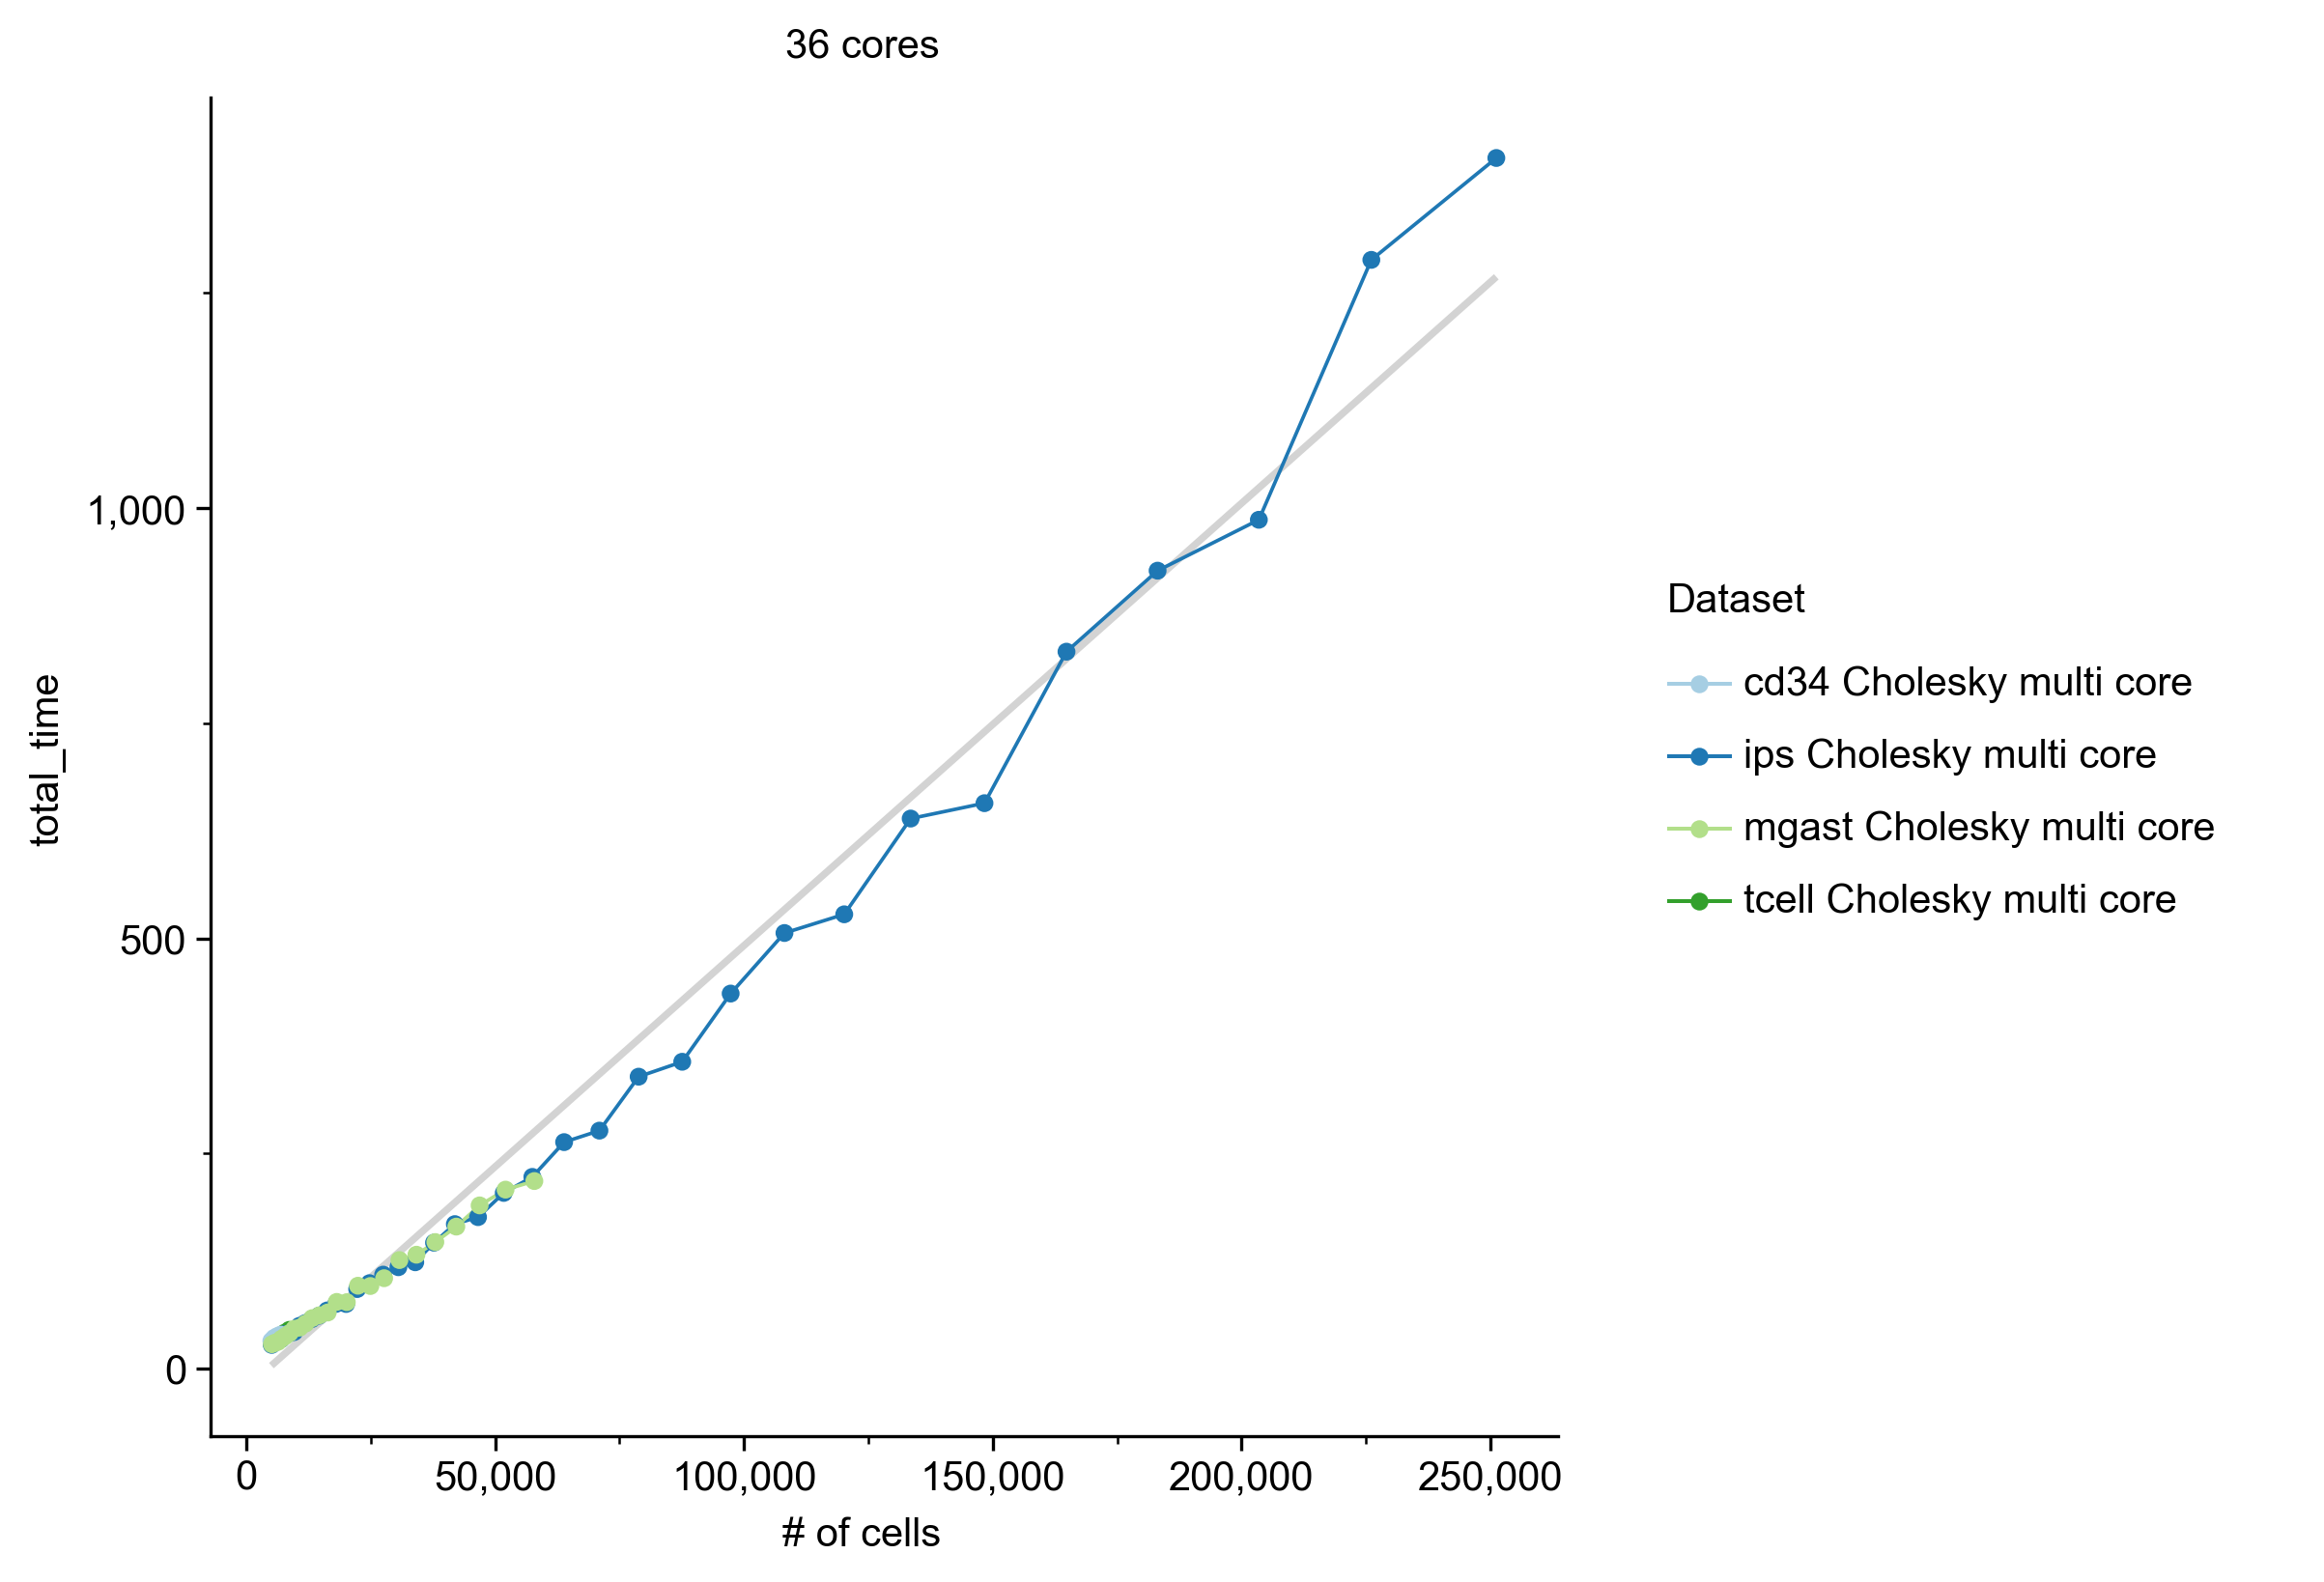

In [17]:
jump = 5000
idx = (stats["n_obs"] > jump) & ((stats["cores"] == 36)) & ((~stats["nystrom"])) & ((~stats["fractal"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"36 cores")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

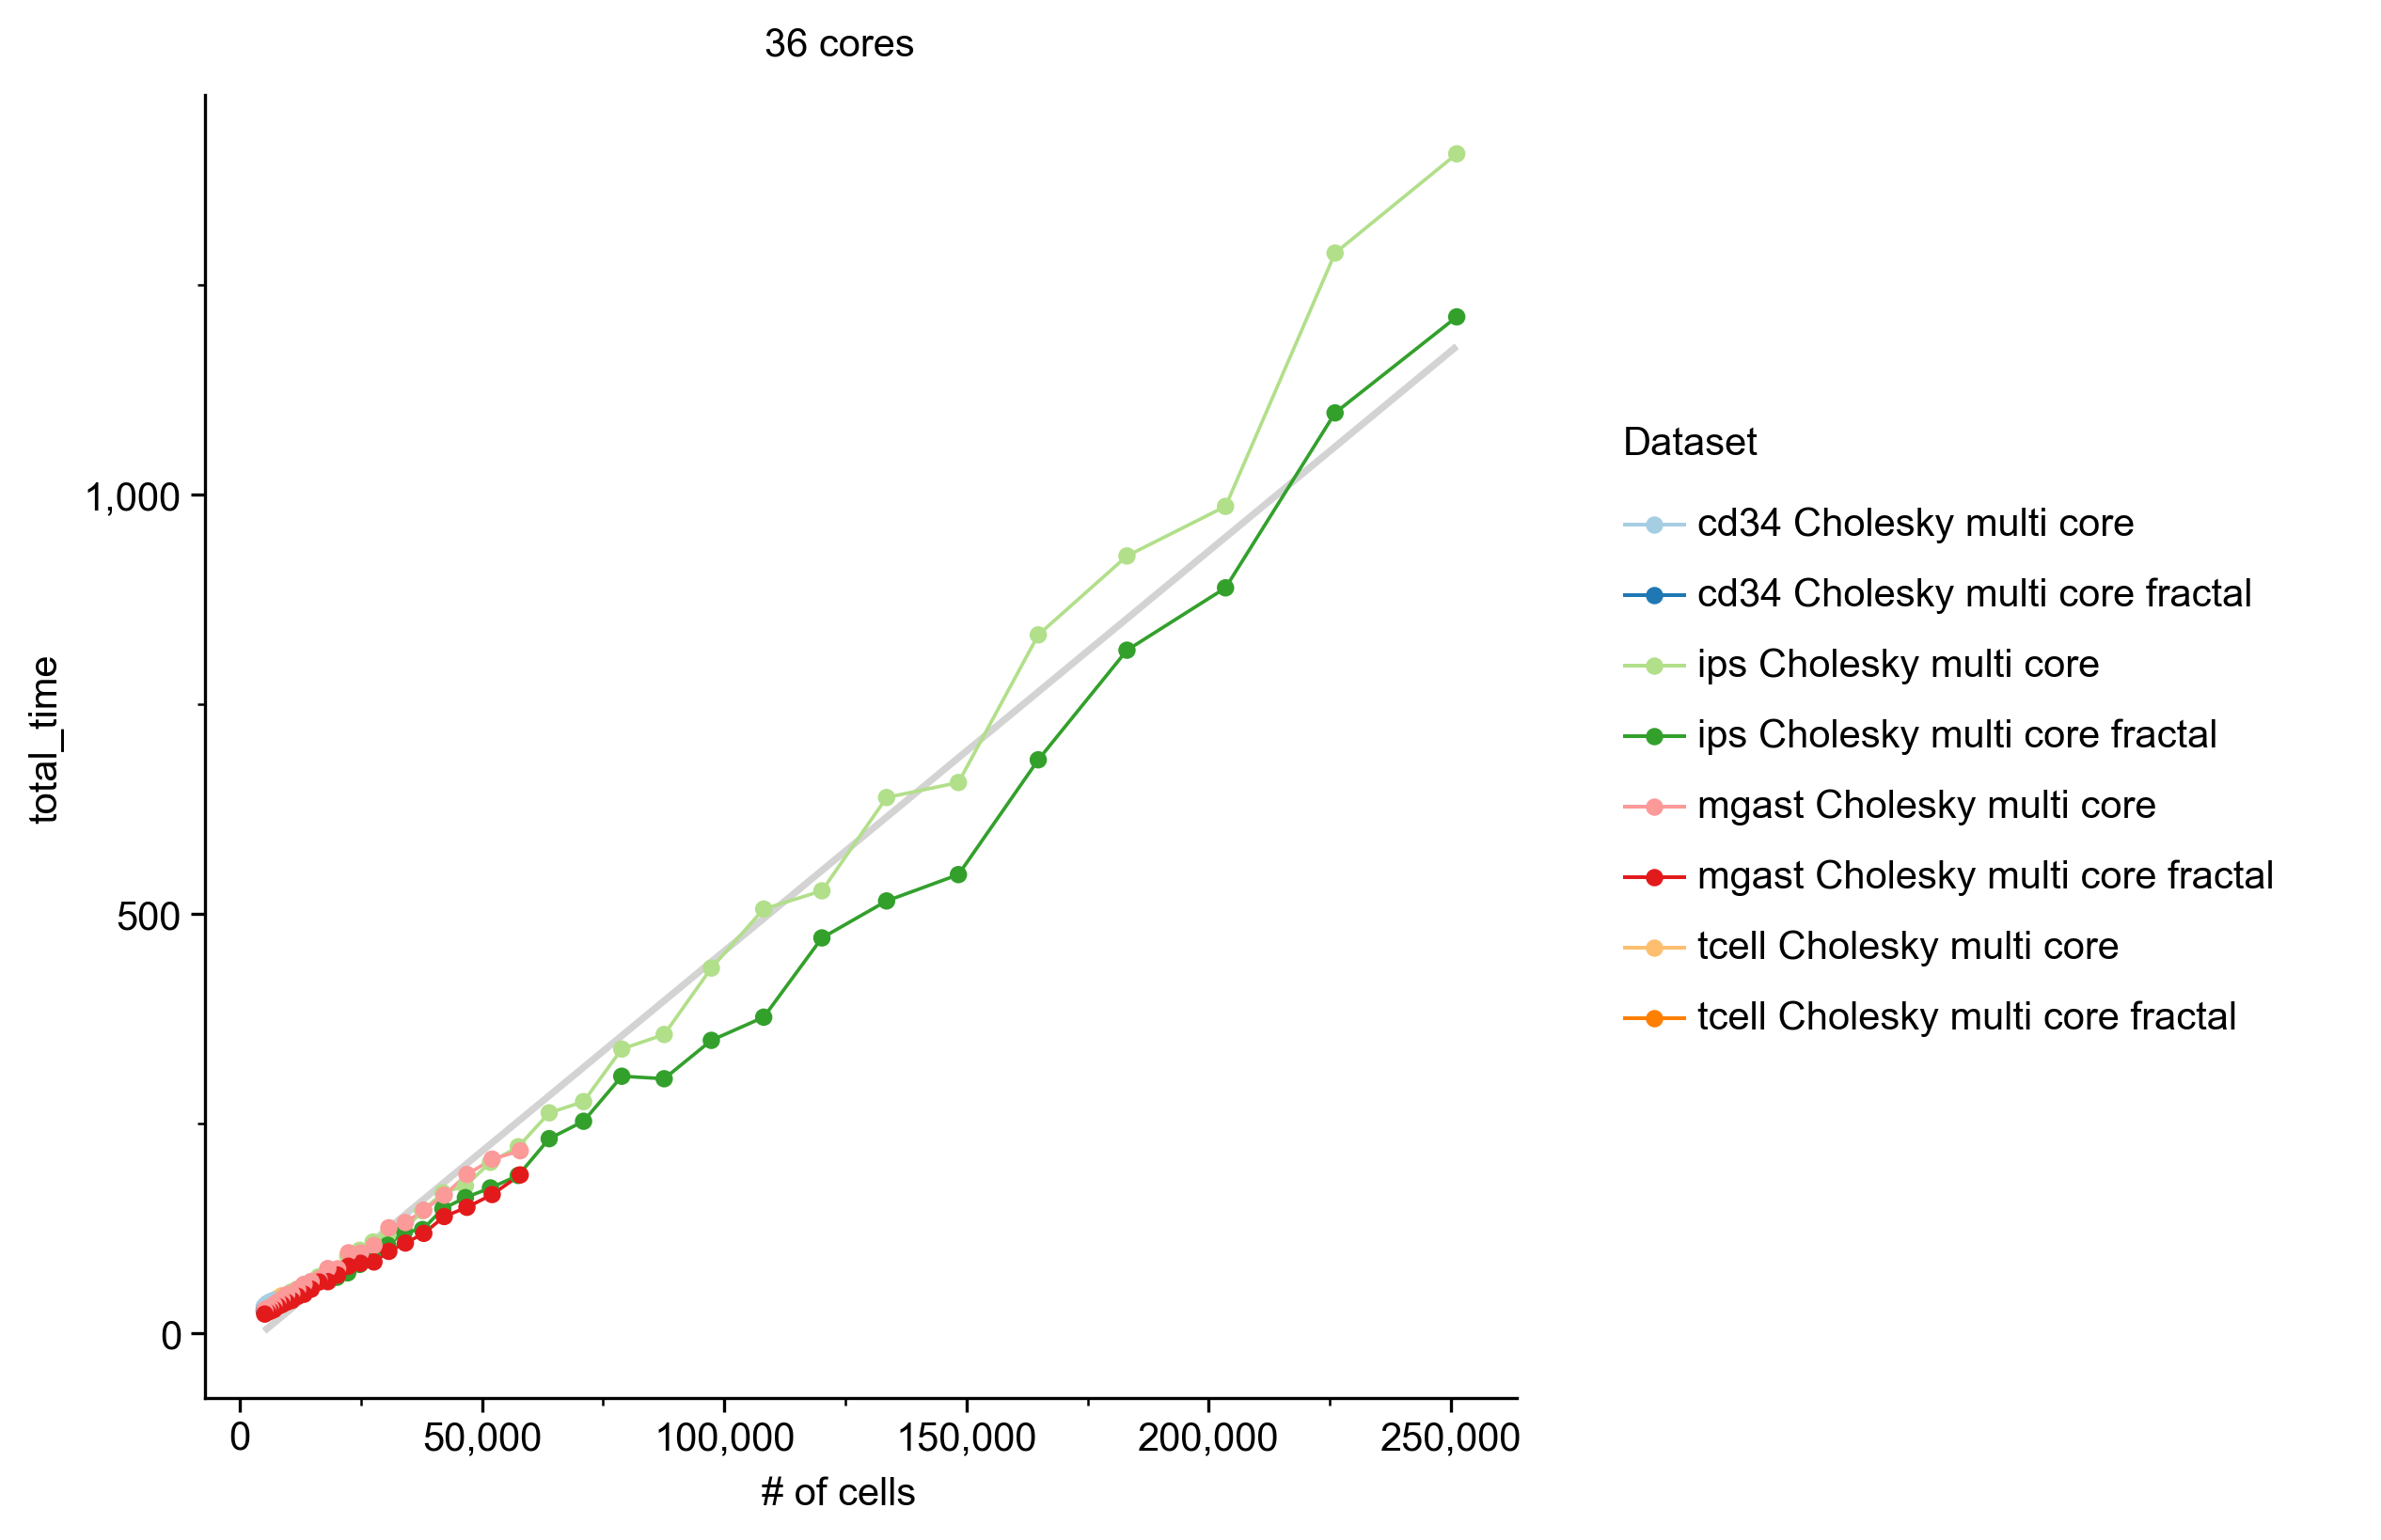

In [18]:
jump = 5000
idx = (stats["n_obs"] > jump) & ((stats["cores"] == 36)) & ((~stats["nystrom"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"36 cores")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

# No predictive function

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_stack requires non-overlapping x intervals


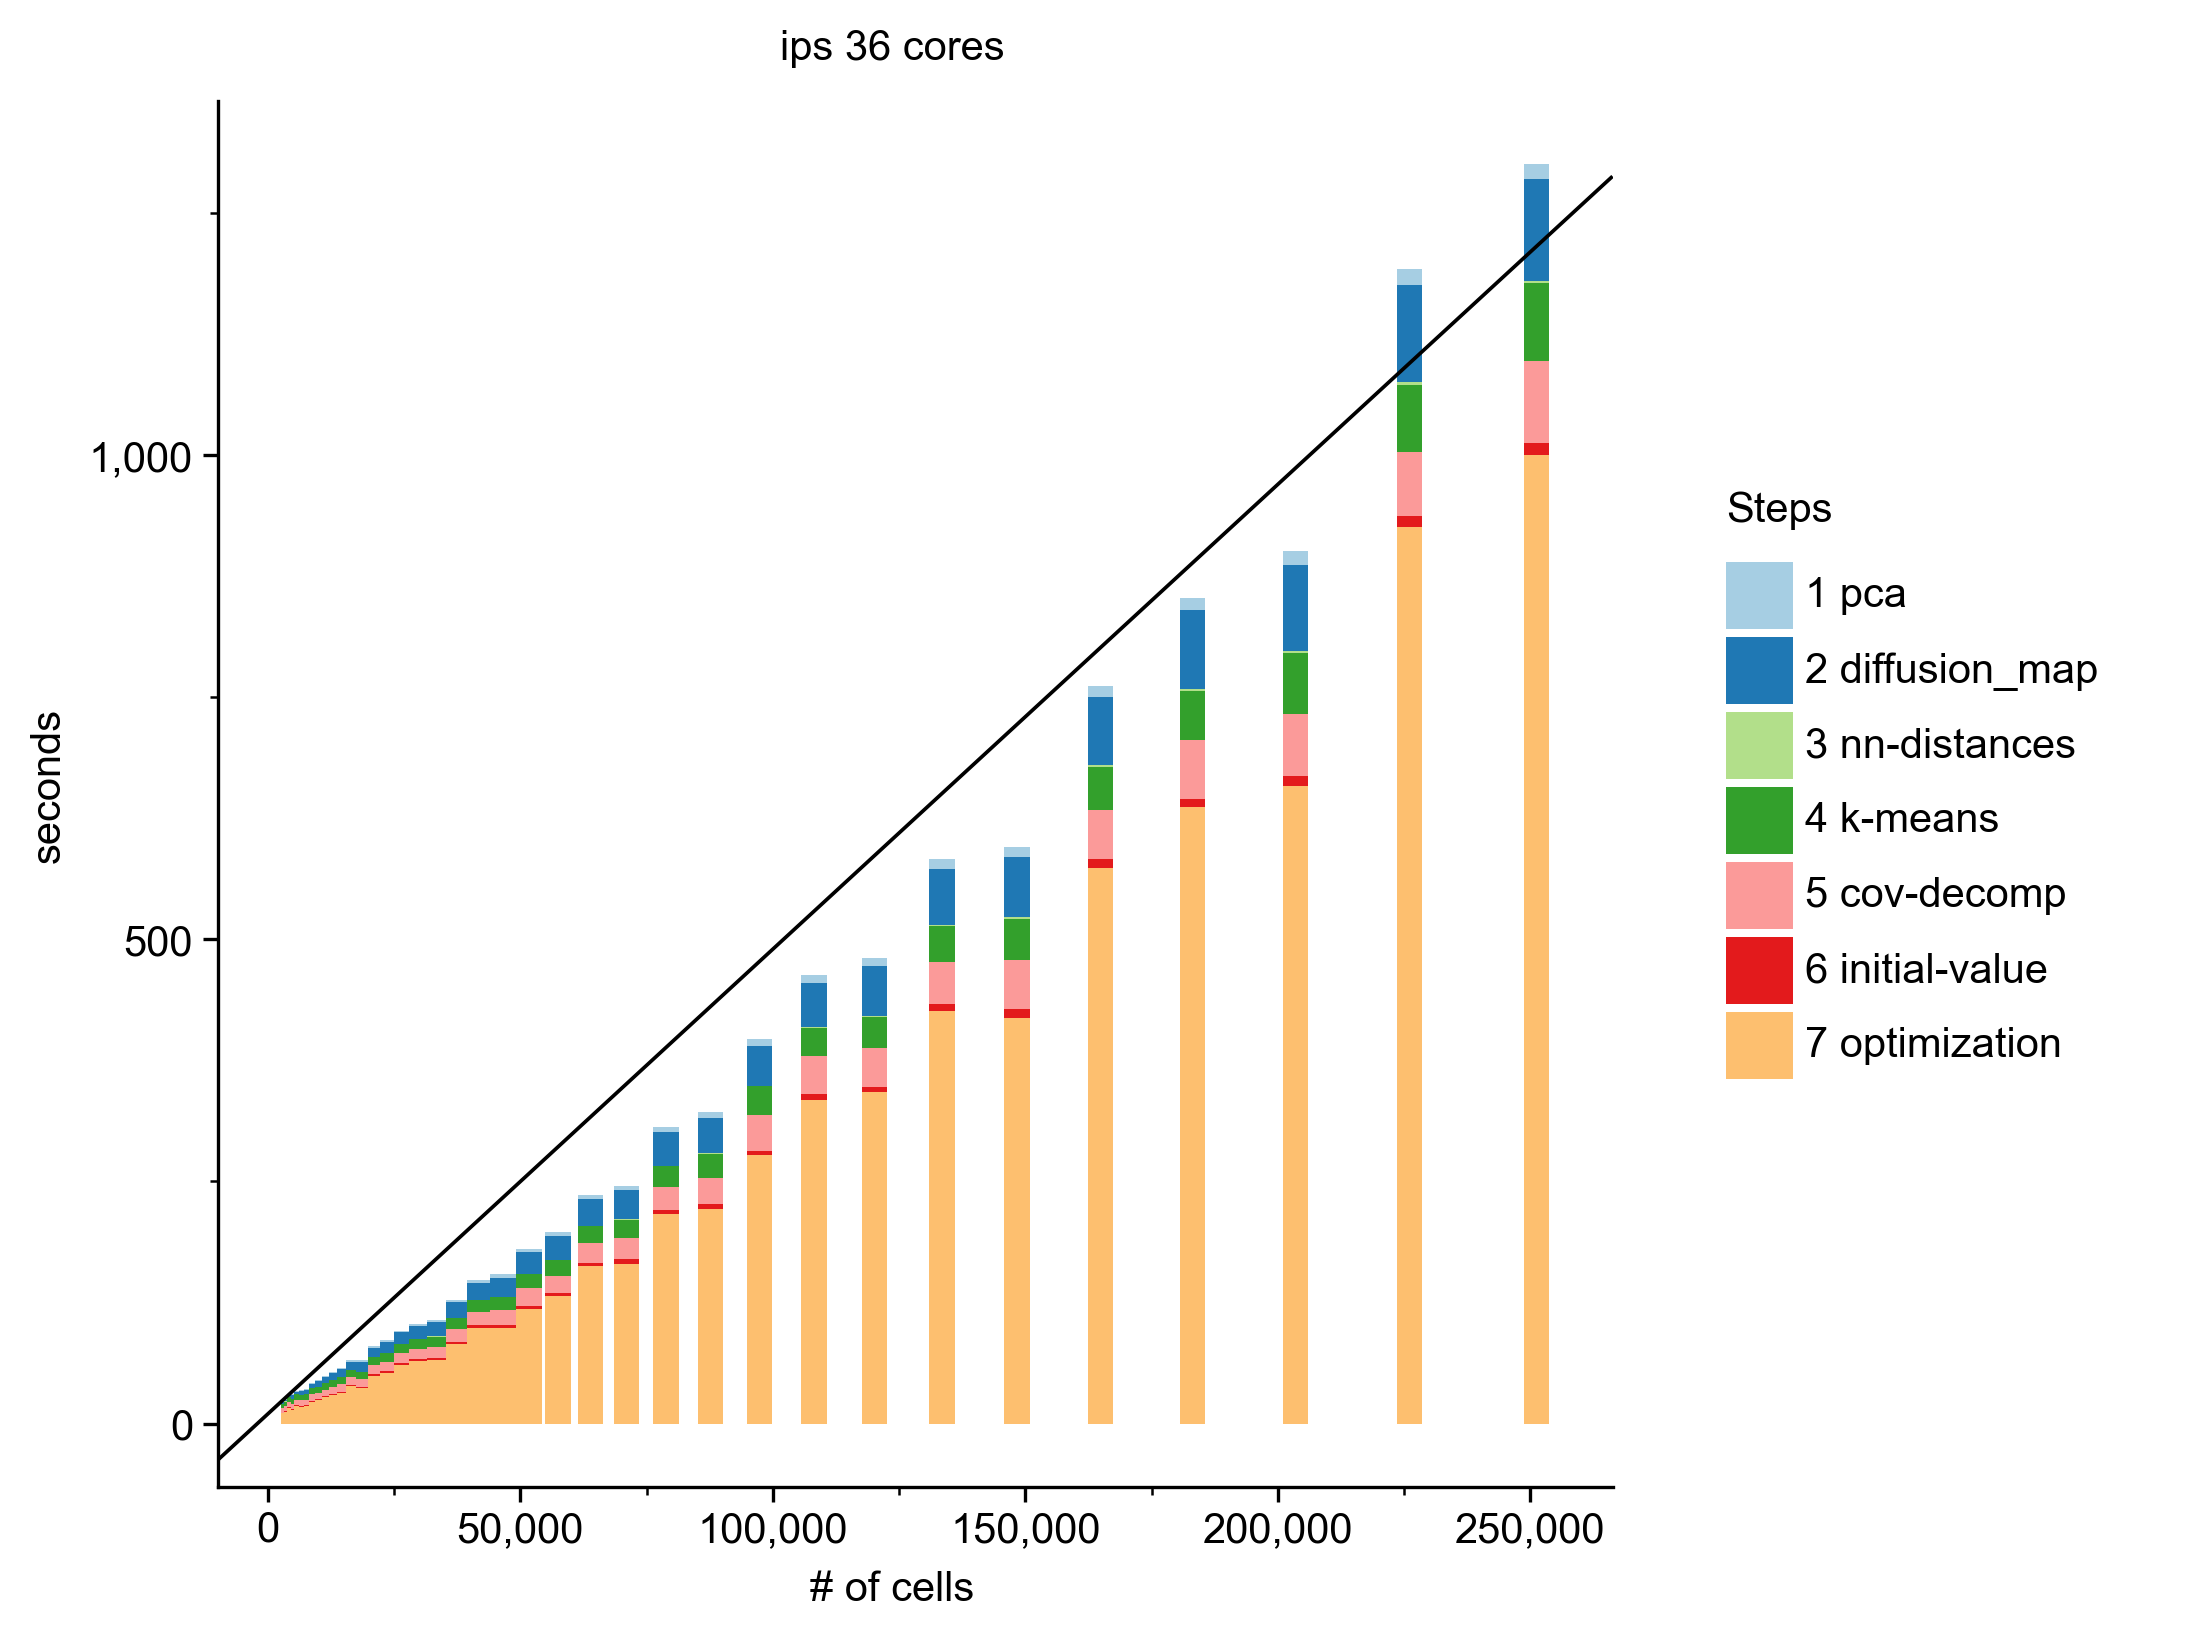

In [19]:
ds_name = "ips"
method = "hierarchical_noNy"

titel = f"{ds_name} 36 cores"
idx = (stats["dataset"] == ds_name) & (stats["mode"] == method)
idx &= stats["n_obs"] >= 5000
sub_stats = stats.loc[
    idx,
    list(sub_calls)
    + [
        "n_obs",
    ],
].melt(id_vars="n_obs", value_name="seconds")
sub_stats["seconds"] = sub_stats["seconds"].astype(float)
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "seconds", fill="variable"))
    + p9.geom_bar(position="stack", stat="identity", width=5000)
    + p9.ggtitle(titel)
    + p9.xlab("# of cells")
    + p9.theme_matplotlib()
    + p9.geom_abline(intercept=10, slope=48e-4)
    + p9.labs(fill = "Steps")
    + p9.scales.scale_fill_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_stack requires non-overlapping x intervals


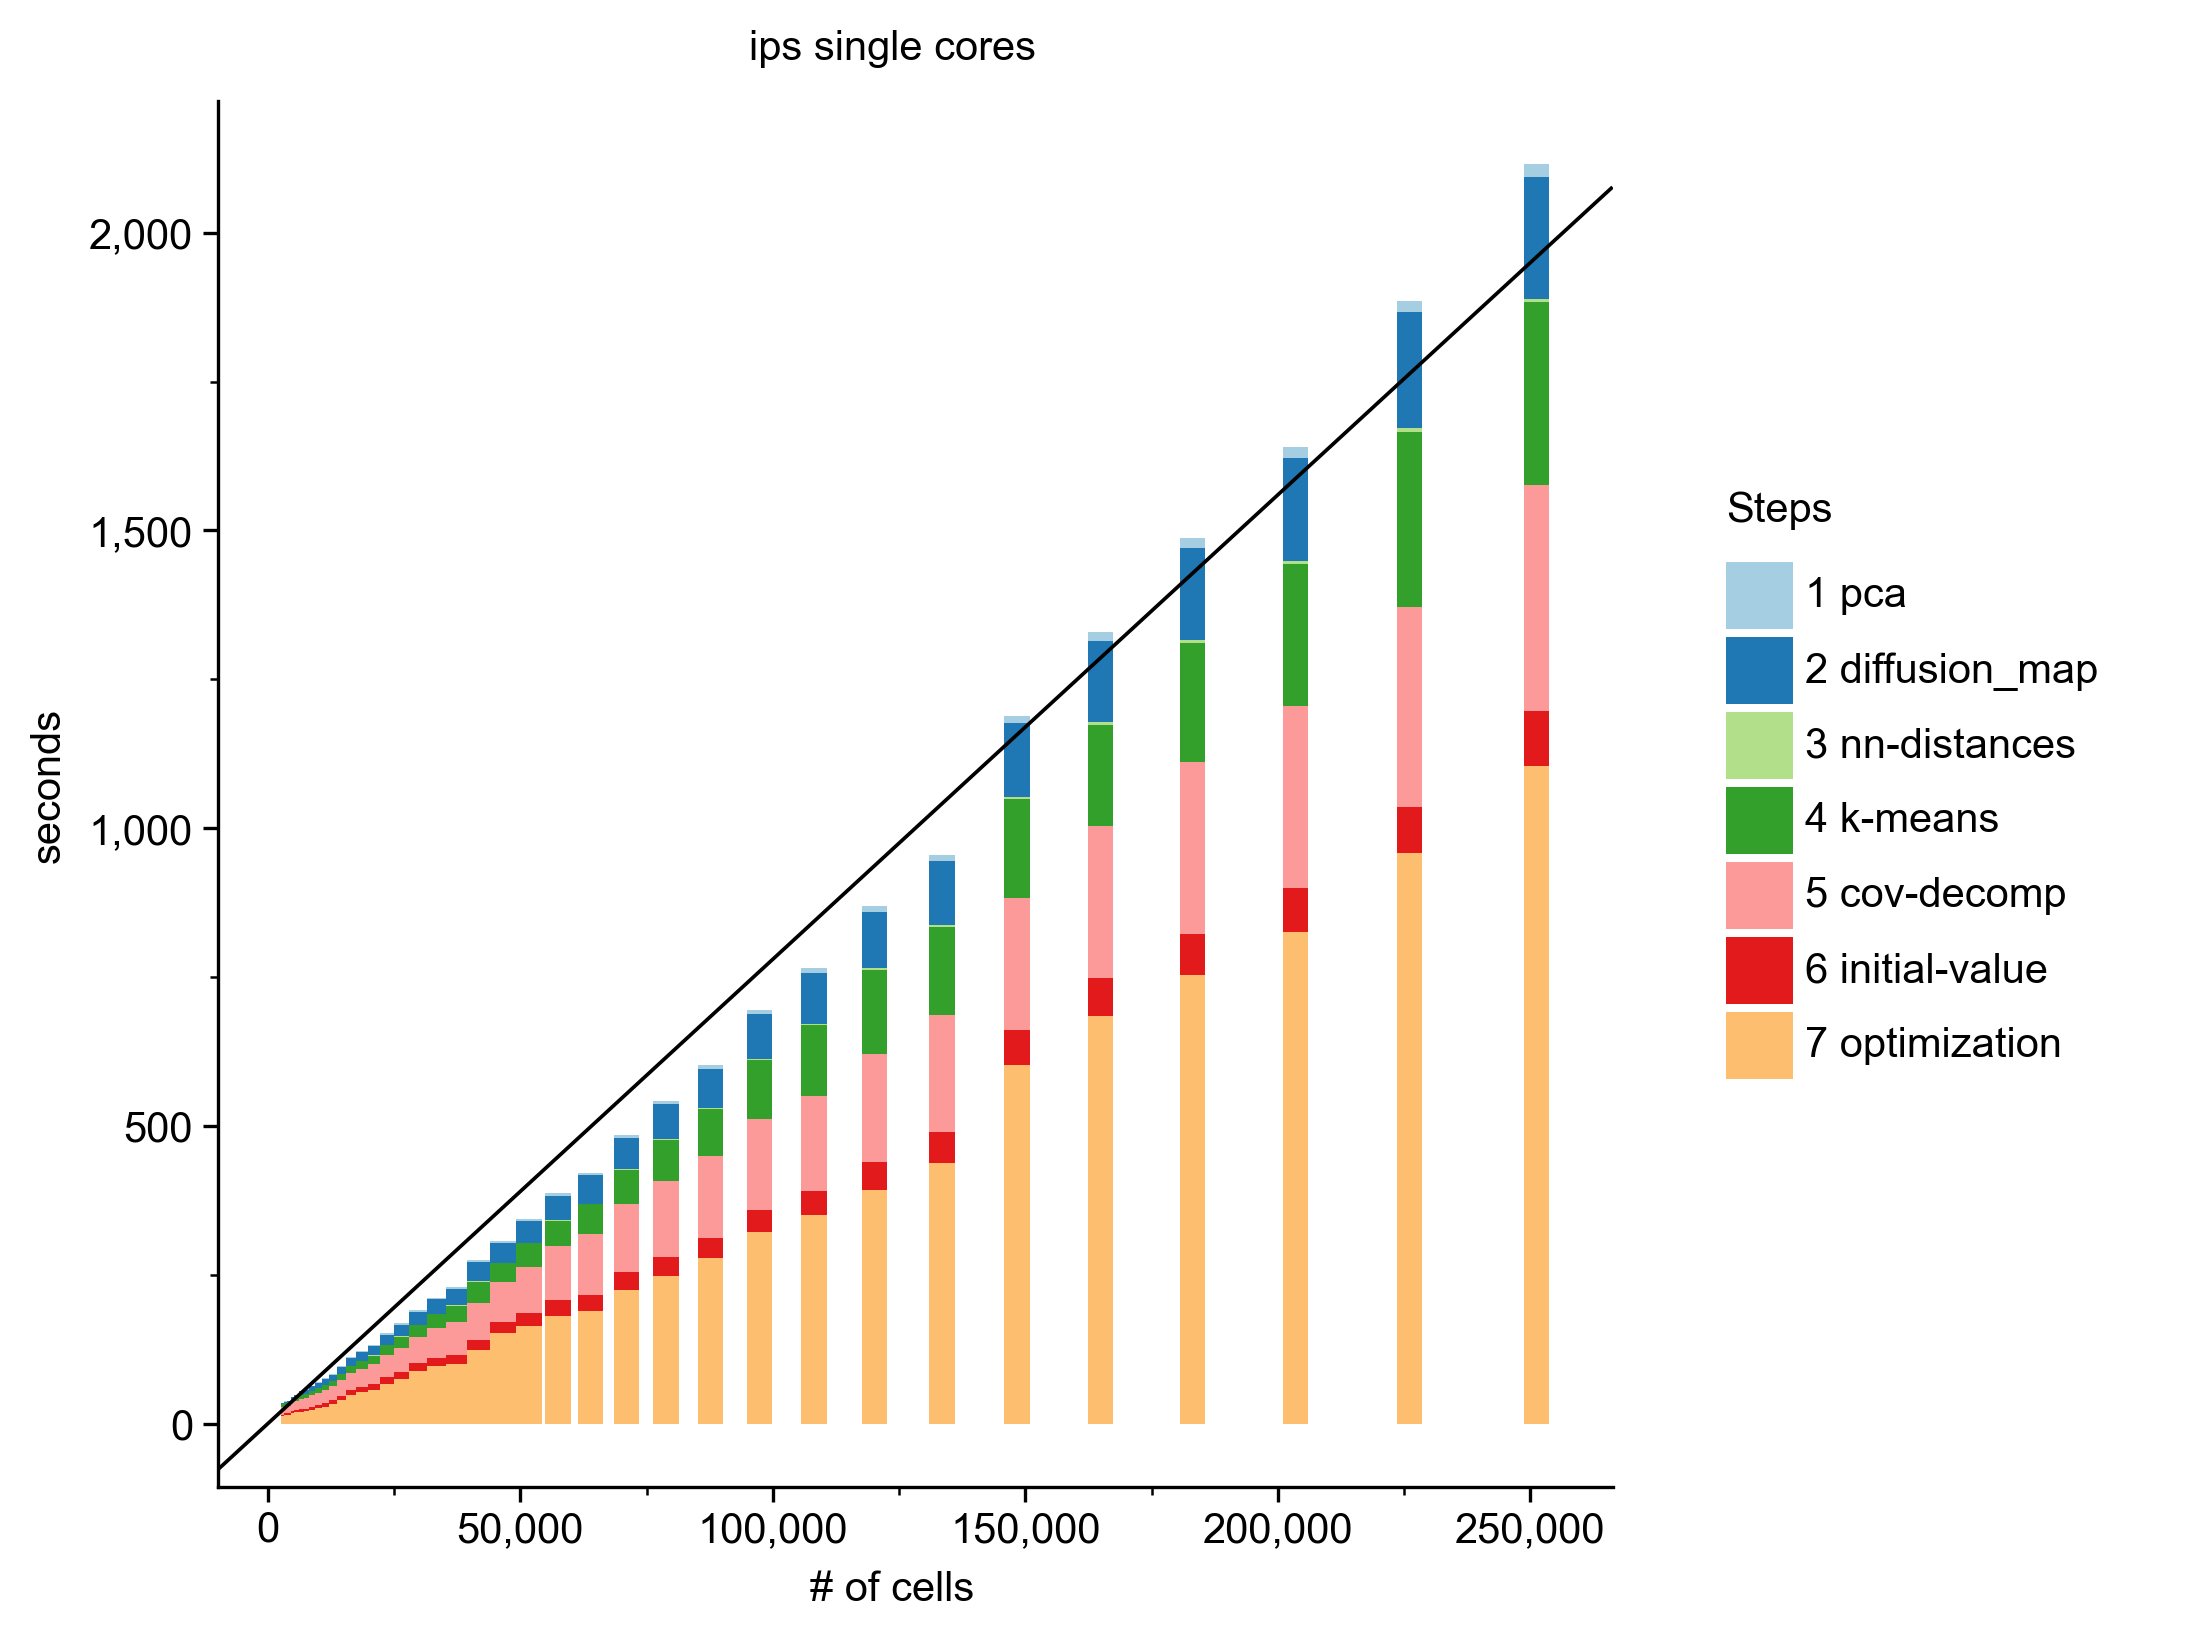

In [20]:
ds_name = "ips"
method = "hierarchical_noNy_1core"

titel = f"{ds_name} single cores"
idx = (stats["dataset"] == ds_name) & (stats["mode"] == method)
idx &= stats["n_obs"] >= 5000
sub_stats = stats.loc[
    idx,
    list(sub_calls)
    + [
        "n_obs",
    ],
].melt(id_vars="n_obs", value_name="seconds")
sub_stats["seconds"] = sub_stats["seconds"].astype(float)
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "seconds", fill="variable"))
    + p9.geom_bar(position="stack", stat="identity", width=5000)
    + p9.ggtitle(titel)
    + p9.xlab("# of cells")
    + p9.theme_matplotlib()
    + p9.geom_abline(intercept=0, slope=78e-4)
    + p9.labs(fill = "Steps")
    + p9.scales.scale_fill_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_stack requires non-overlapping x intervals


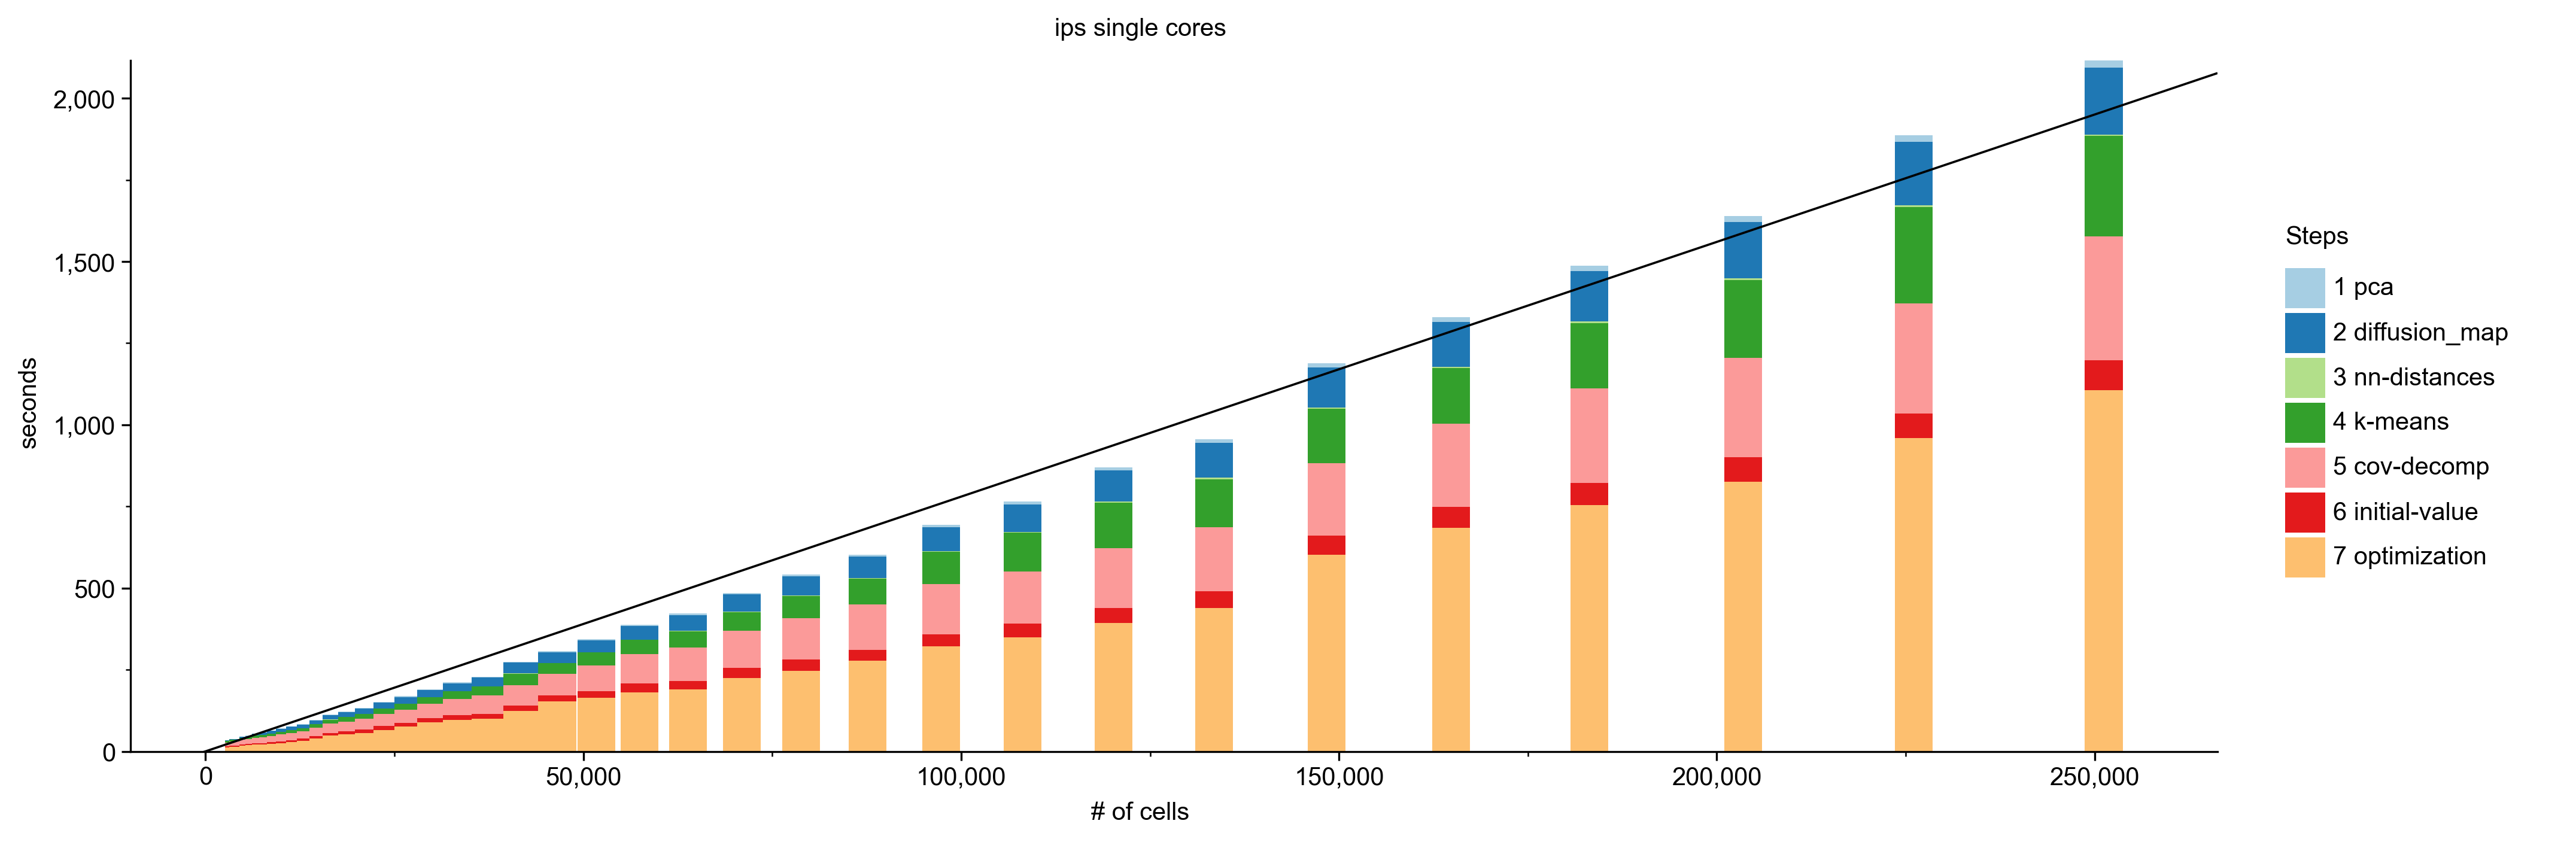

In [21]:
ds_name = "ips"
method = "hierarchical_noNy_1core"
p9.options.figure_size = (15, 5)

titel = f"{ds_name} single cores"
idx = (stats["dataset"] == ds_name) & (stats["mode"] == method)
idx &= stats["n_obs"] >= 5000
sub_stats = stats.loc[
    idx,
    list(sub_calls)
    + [
        "n_obs",
    ],
].melt(id_vars="n_obs", value_name="seconds")
sub_stats["seconds"] = sub_stats["seconds"].astype(float)
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "seconds", fill="variable"))
    + p9.geom_bar(position="stack", stat="identity", width=5000)
    + p9.ggtitle(titel)
    + p9.xlab("# of cells")
    + p9.theme_matplotlib()
    + p9.geom_abline(intercept=0, slope=78e-4)
    + p9.labs(fill = "Steps")
    + p9.scales.scale_fill_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x], limits = (0, None), expand = (0, .1))
)
print(pl)

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_stack requires non-overlapping x intervals


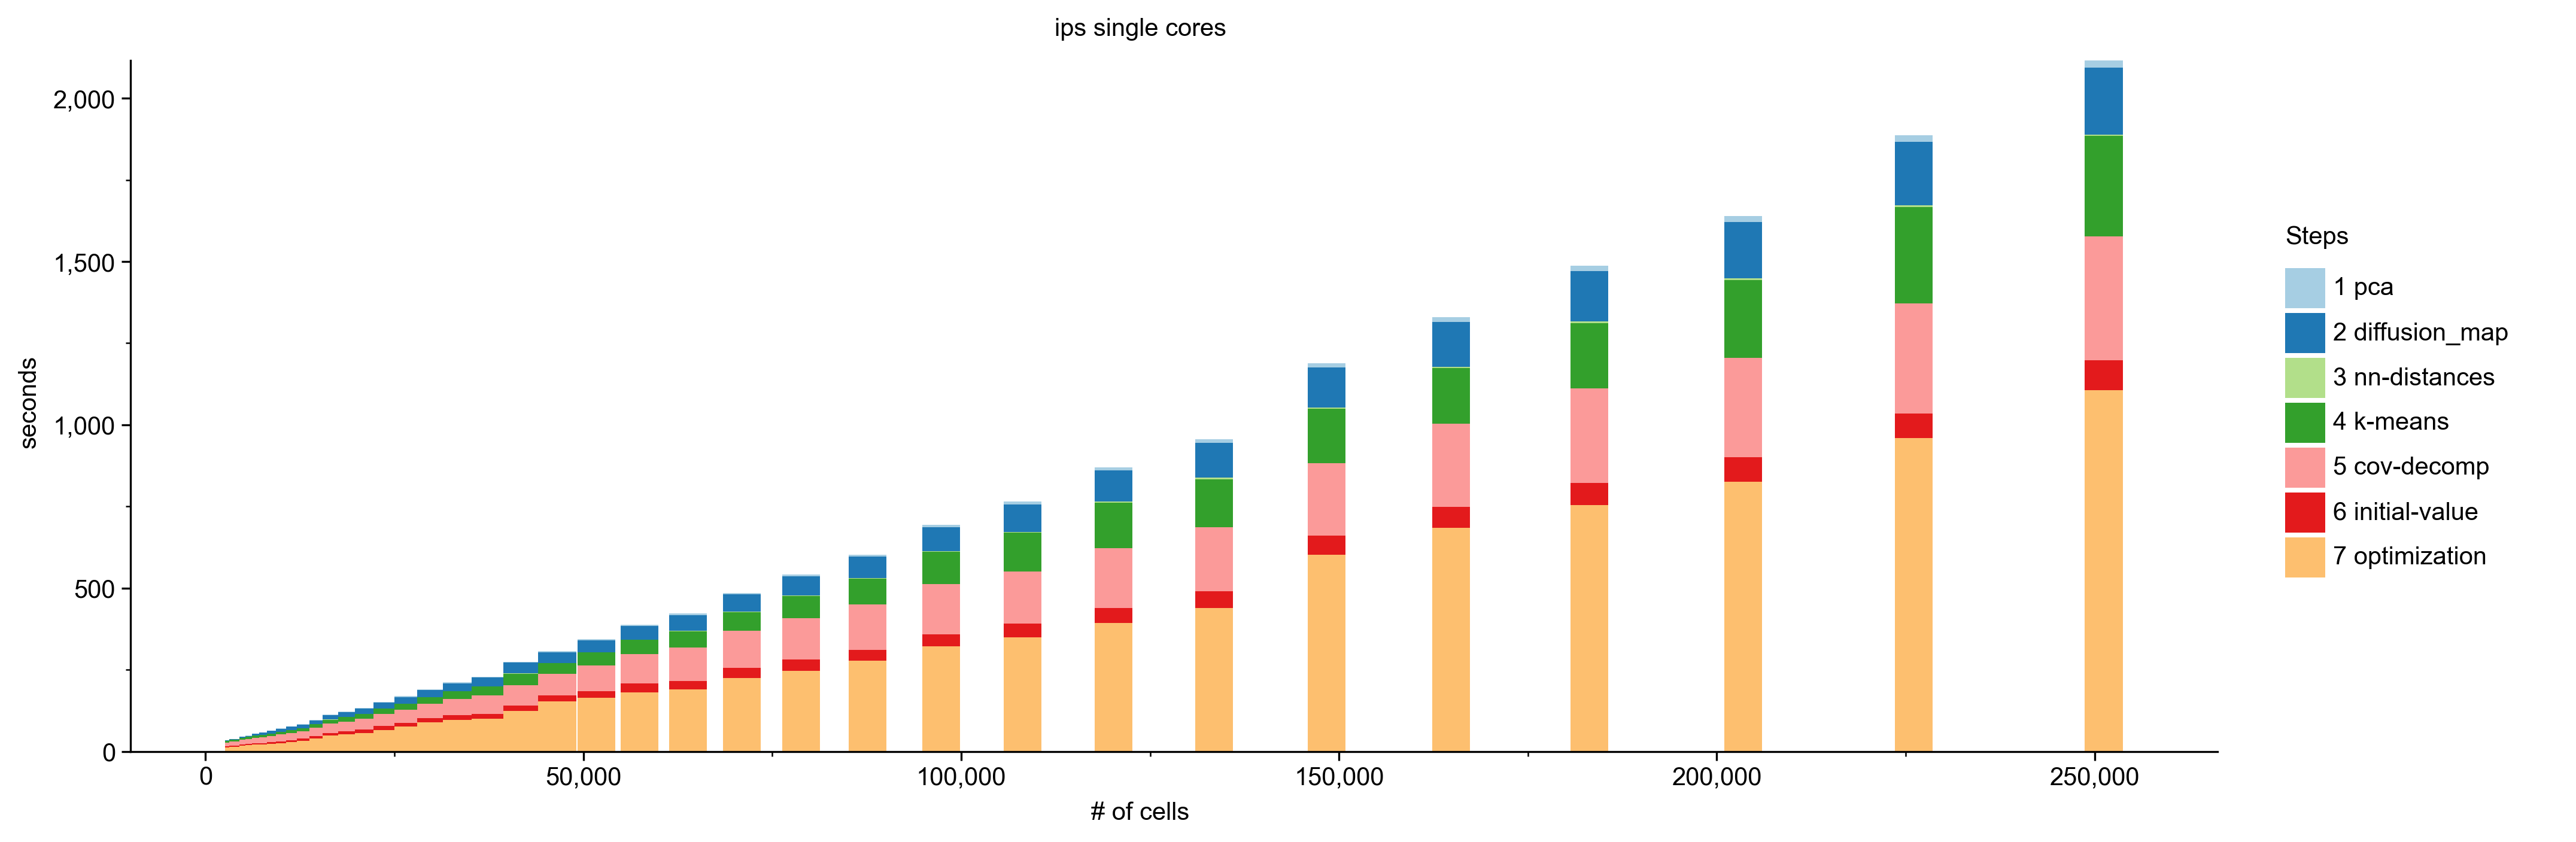

In [22]:
ds_name = "ips"
method = "hierarchical_noNy_1core"
p9.options.figure_size = (15, 5)

titel = f"{ds_name} single cores"
idx = (stats["dataset"] == ds_name) & (stats["mode"] == method)
idx &= stats["n_obs"] >= 5000
sub_stats = stats.loc[
    idx,
    list(sub_calls)
    + [
        "n_obs",
    ],
].melt(id_vars="n_obs", value_name="seconds")
sub_stats["seconds"] = sub_stats["seconds"].astype(float)
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "seconds", fill="variable"))
    + p9.geom_bar(position="stack", stat="identity", width=5000)
    + p9.ggtitle(titel)
    + p9.xlab("# of cells")
    + p9.theme_matplotlib()
    #+ p9.geom_abline(intercept=0, slope=78e-4)
    + p9.labs(fill = "Steps")
    + p9.scales.scale_fill_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x], limits = (0, None), expand = (0, .1))
)
print(pl)

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_stack requires non-overlapping x intervals


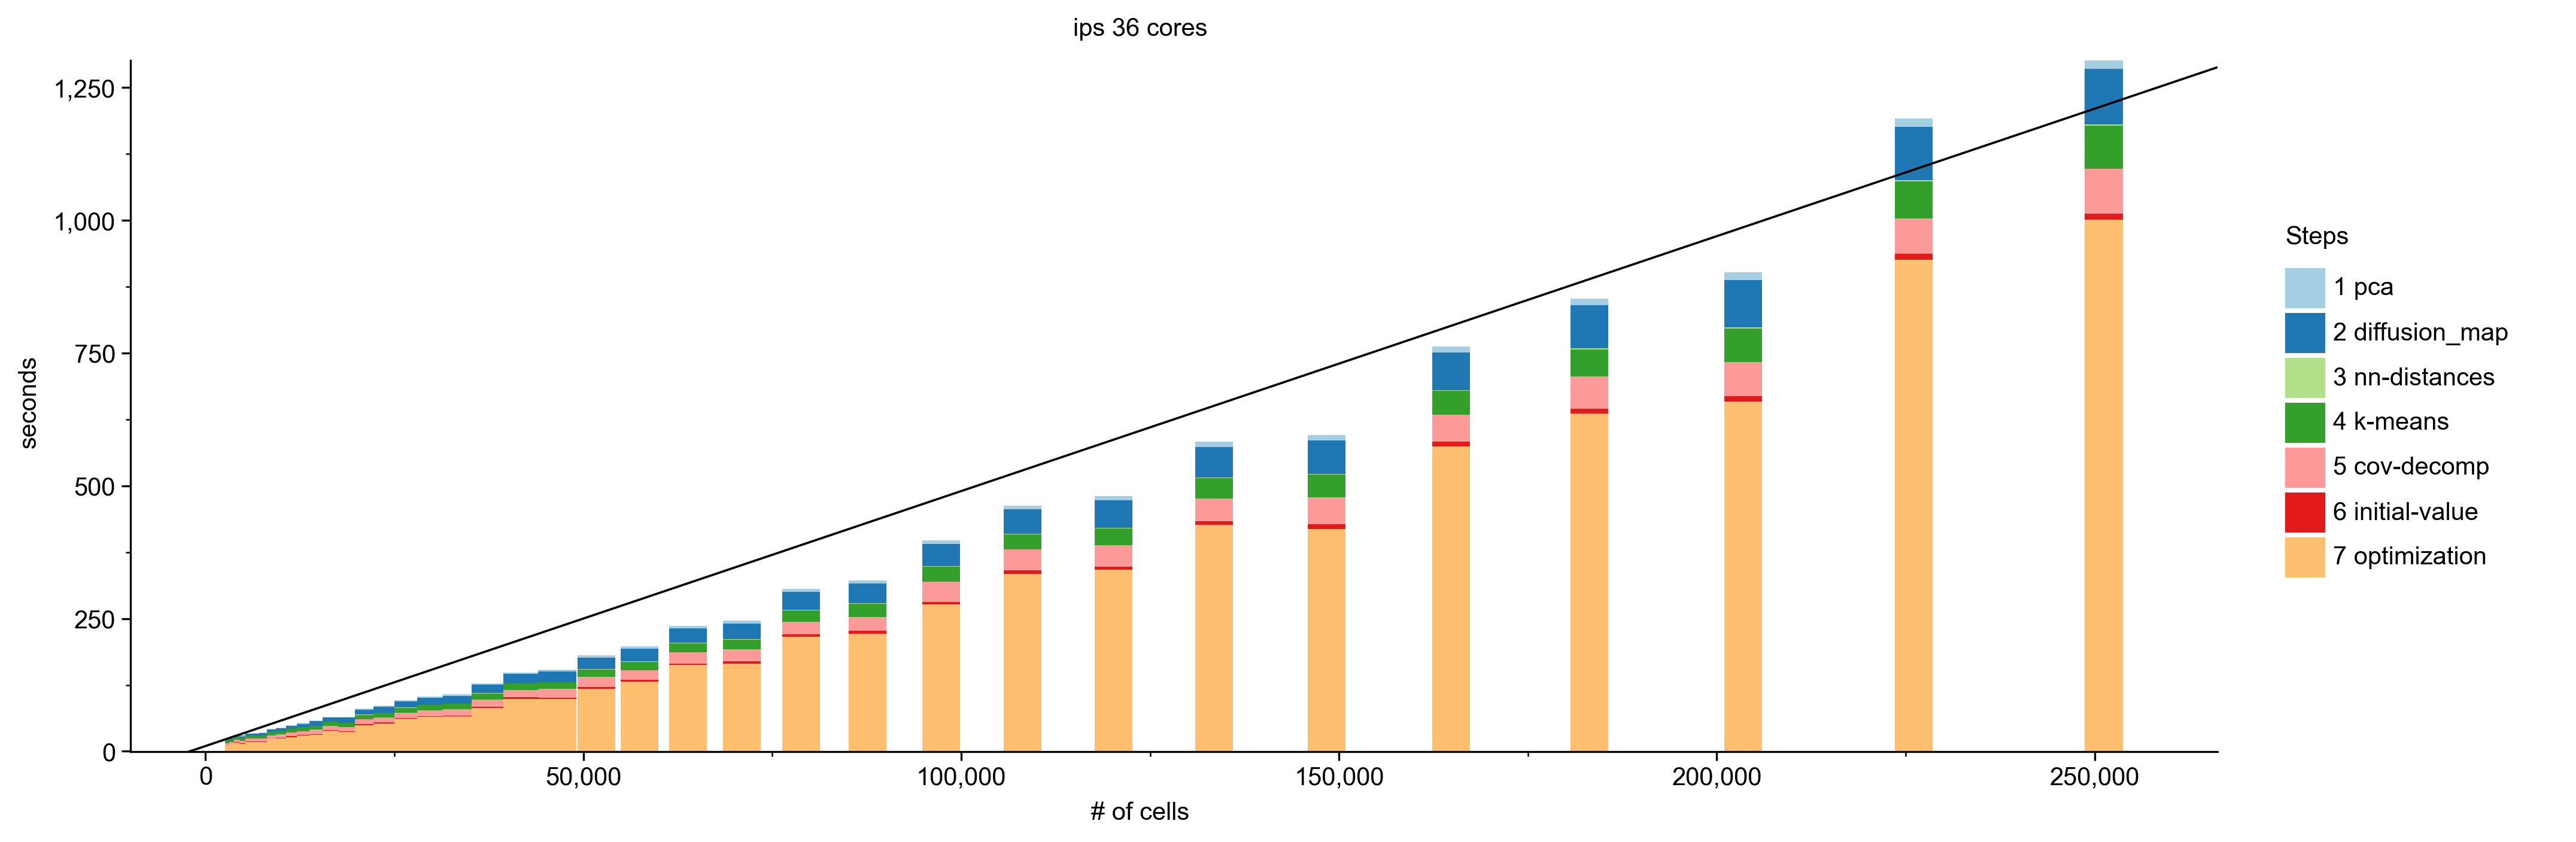

In [23]:
ds_name = "ips"
method = "hierarchical_noNy"

titel = f"{ds_name} 36 cores"
idx = (stats["dataset"] == ds_name) & (stats["mode"] == method)
idx &= stats["n_obs"] >= 5000
sub_stats = stats.loc[
    idx,
    list(sub_calls)
    + [
        "n_obs",
    ],
].melt(id_vars="n_obs", value_name="seconds")
sub_stats["seconds"] = sub_stats["seconds"].astype(float)
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "seconds", fill="variable"))
    + p9.geom_bar(position="stack", stat="identity", width=5000)
    + p9.ggtitle(titel)
    + p9.xlab("# of cells")
    + p9.theme_matplotlib()
    + p9.geom_abline(intercept=10, slope=48e-4)
    + p9.labs(fill = "Steps")
    + p9.scales.scale_fill_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x], limits = (0, None), expand = (0, .1))
)
print(pl)

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/plotnine/positions/position.py:202: PlotnineWarning: position_stack requires non-overlapping x intervals


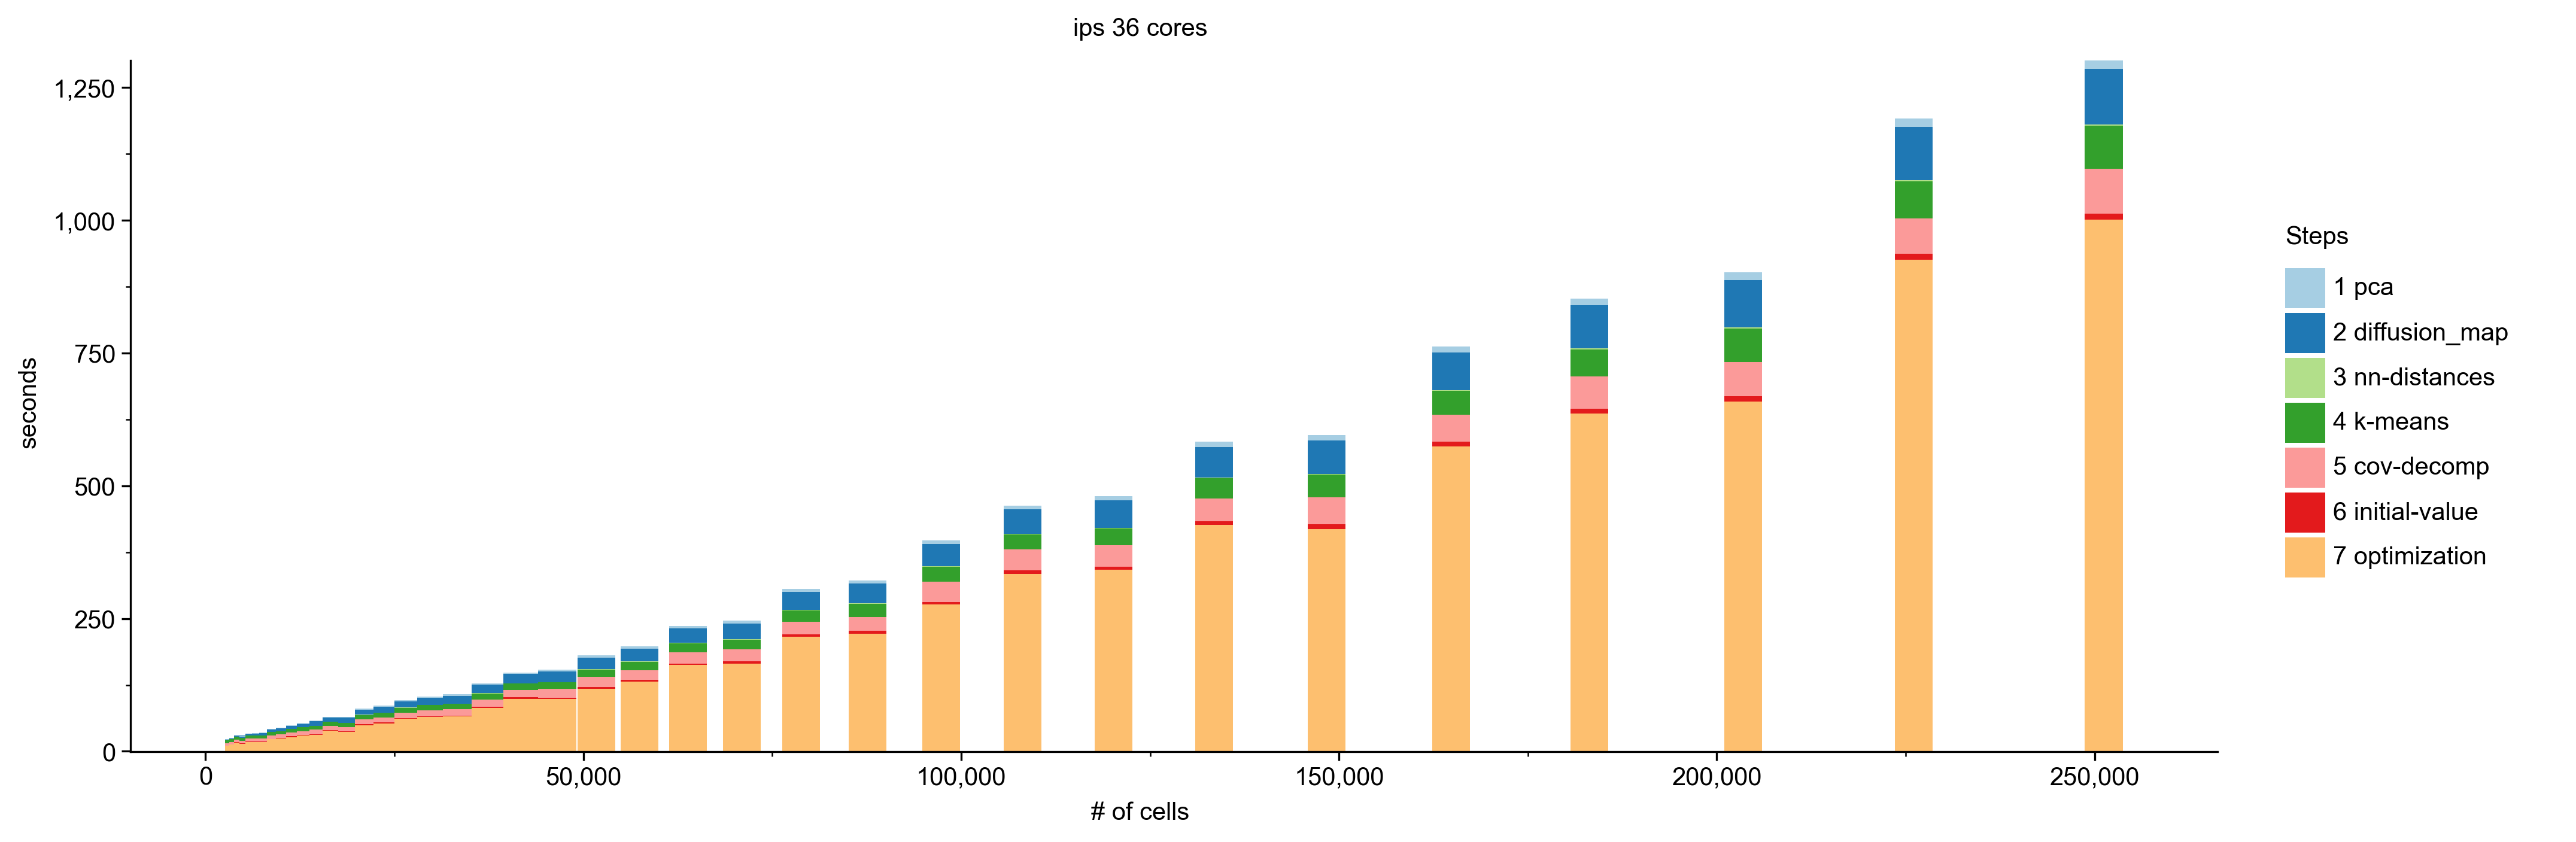

In [24]:
ds_name = "ips"
method = "hierarchical_noNy"

titel = f"{ds_name} 36 cores"
idx = (stats["dataset"] == ds_name) & (stats["mode"] == method)
idx &= stats["n_obs"] >= 5000
sub_stats = stats.loc[
    idx,
    list(sub_calls)
    + [
        "n_obs",
    ],
].melt(id_vars="n_obs", value_name="seconds")
sub_stats["seconds"] = sub_stats["seconds"].astype(float)
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "seconds", fill="variable"))
    + p9.geom_bar(position="stack", stat="identity", width=5000)
    + p9.ggtitle(titel)
    + p9.xlab("# of cells")
    + p9.theme_matplotlib()
    #+ p9.geom_abline(intercept=10, slope=48e-4)
    + p9.labs(fill = "Steps")
    + p9.scales.scale_fill_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x], limits = (0, None), expand = (0, .1))
)
print(pl)

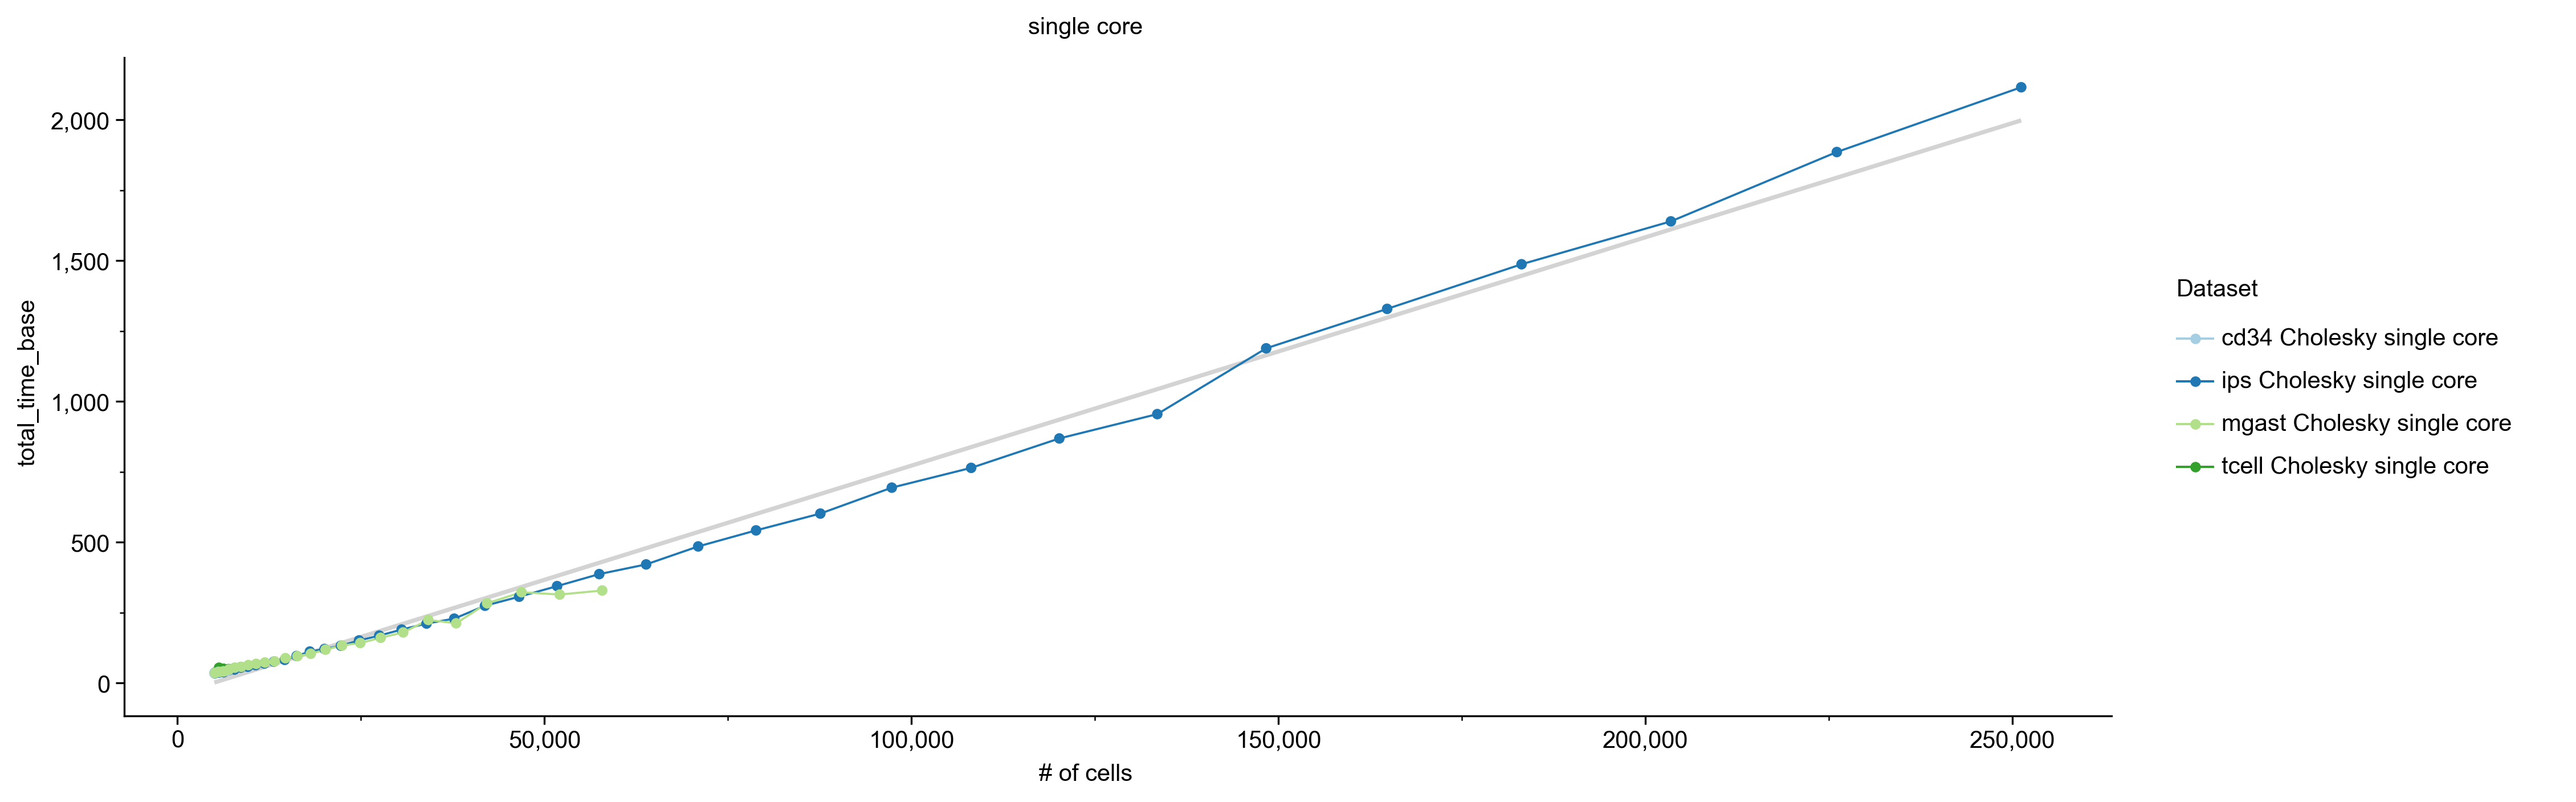

In [25]:
jump = 5000
idx = (stats["n_obs"] > jump) & ((stats["cores"] == 1)) & ((~stats["nystrom"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time_base", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time_base"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"single core")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

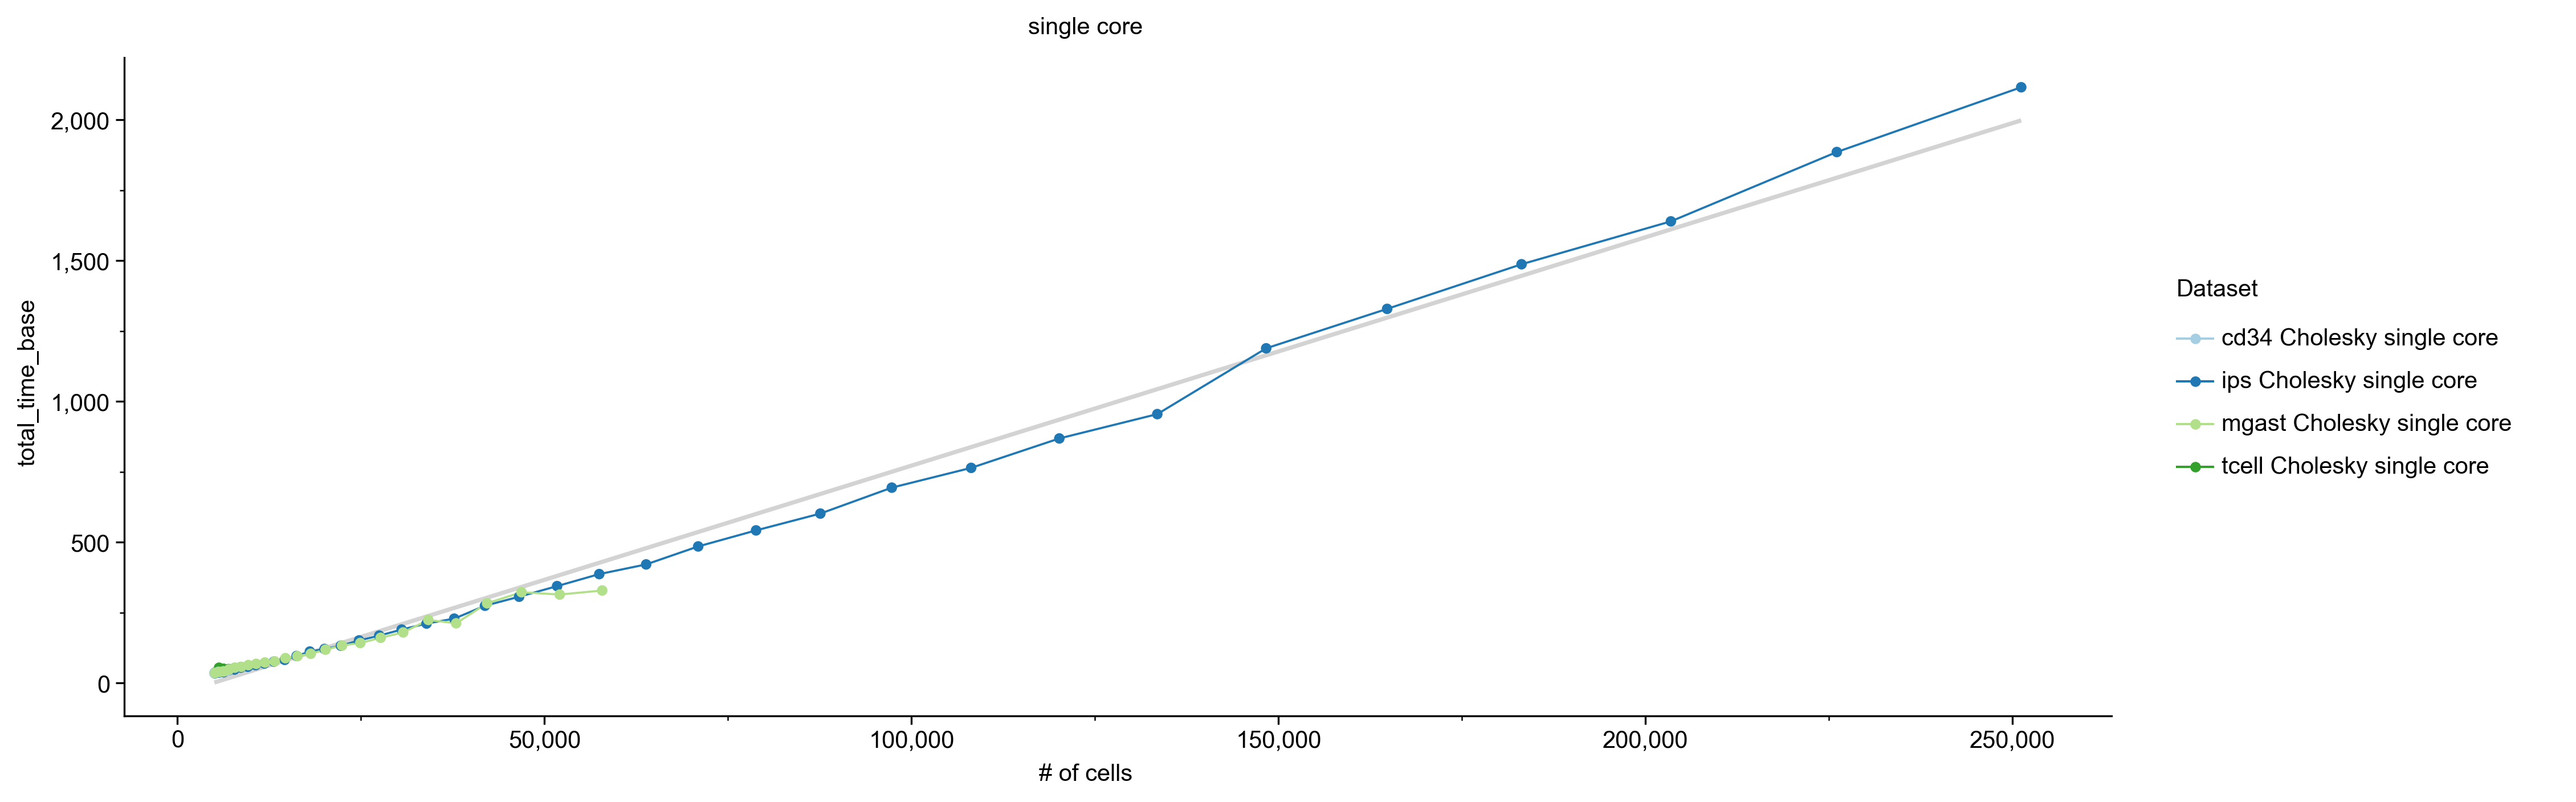

In [26]:
jump = 5000
idx = (stats["n_obs"] > jump) & ((stats["cores"] == 1)) & ((~stats["nystrom"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time_base", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time_base"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"single core")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

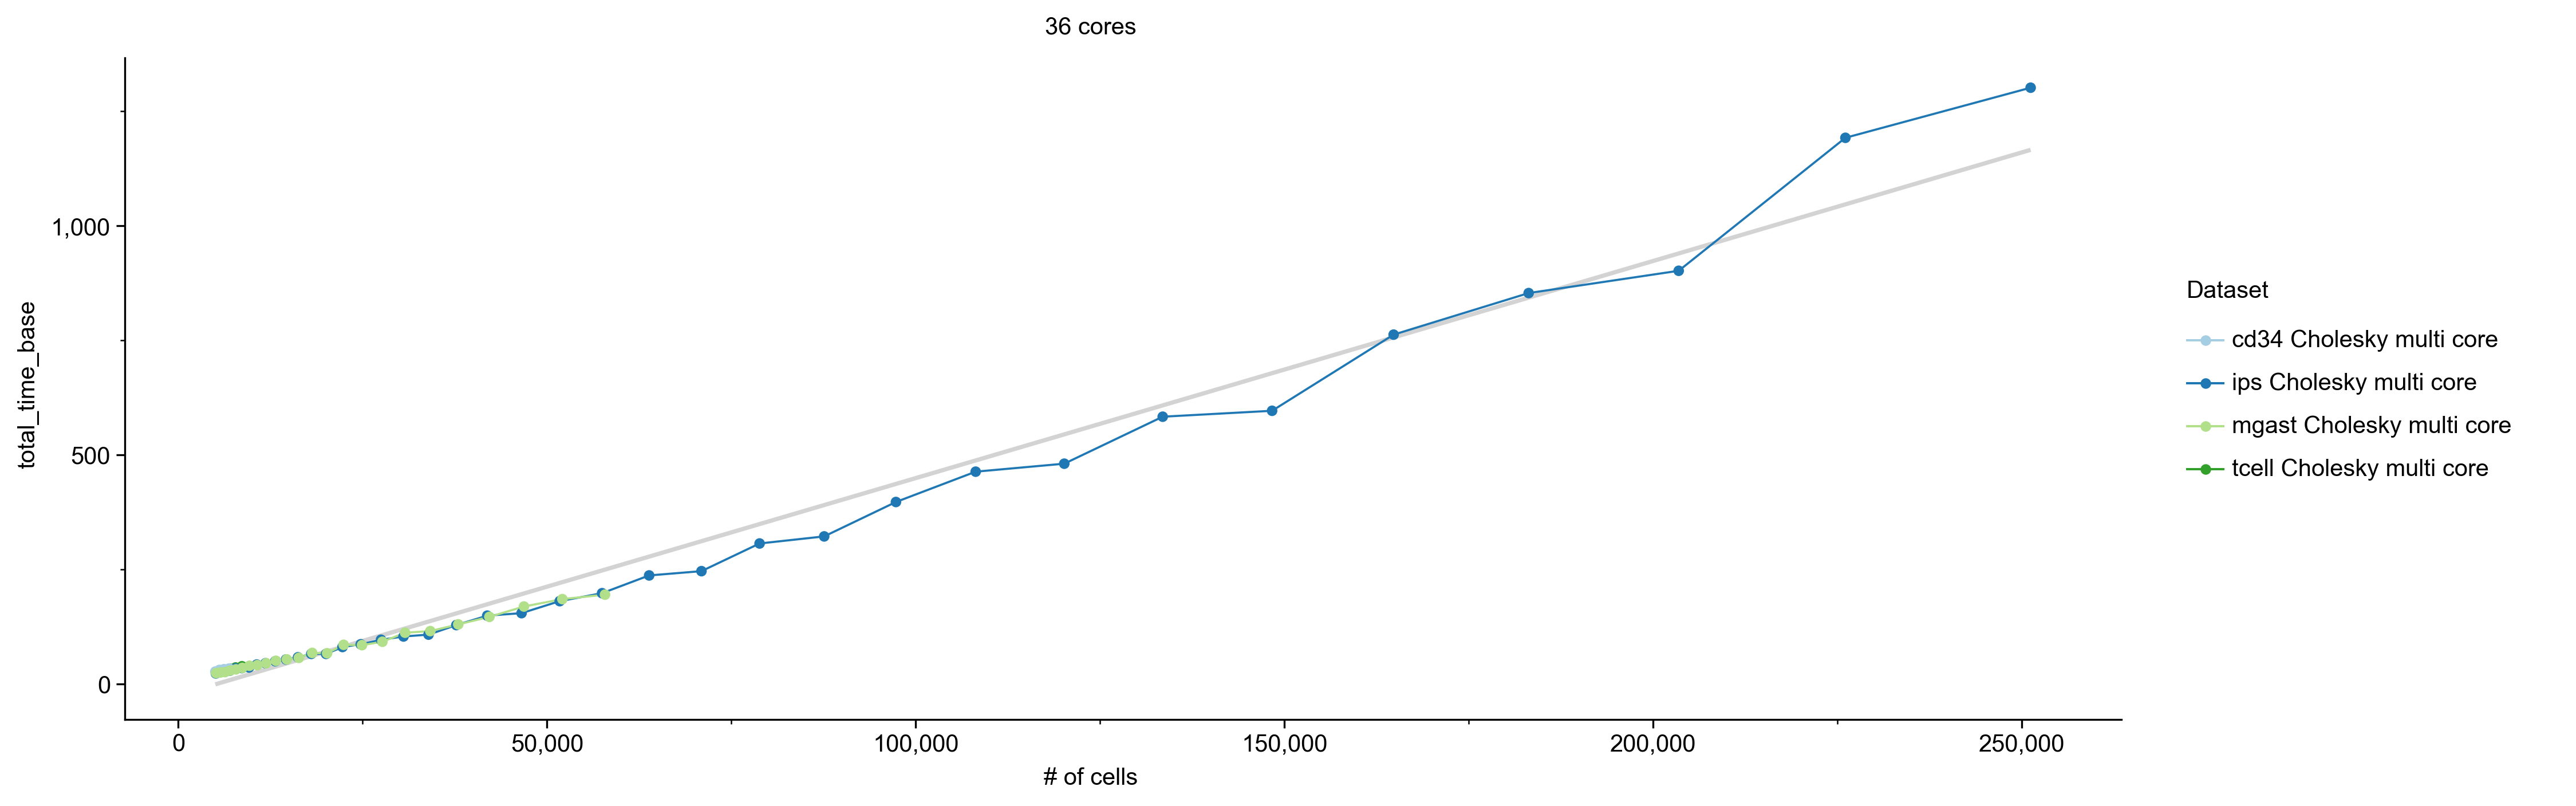

In [27]:
jump = 5000
idx = (stats["n_obs"] > jump) & ((stats["cores"] == 36)) & ((~stats["nystrom"])) & ((~stats["fractal"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time_base", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time_base"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"36 cores")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

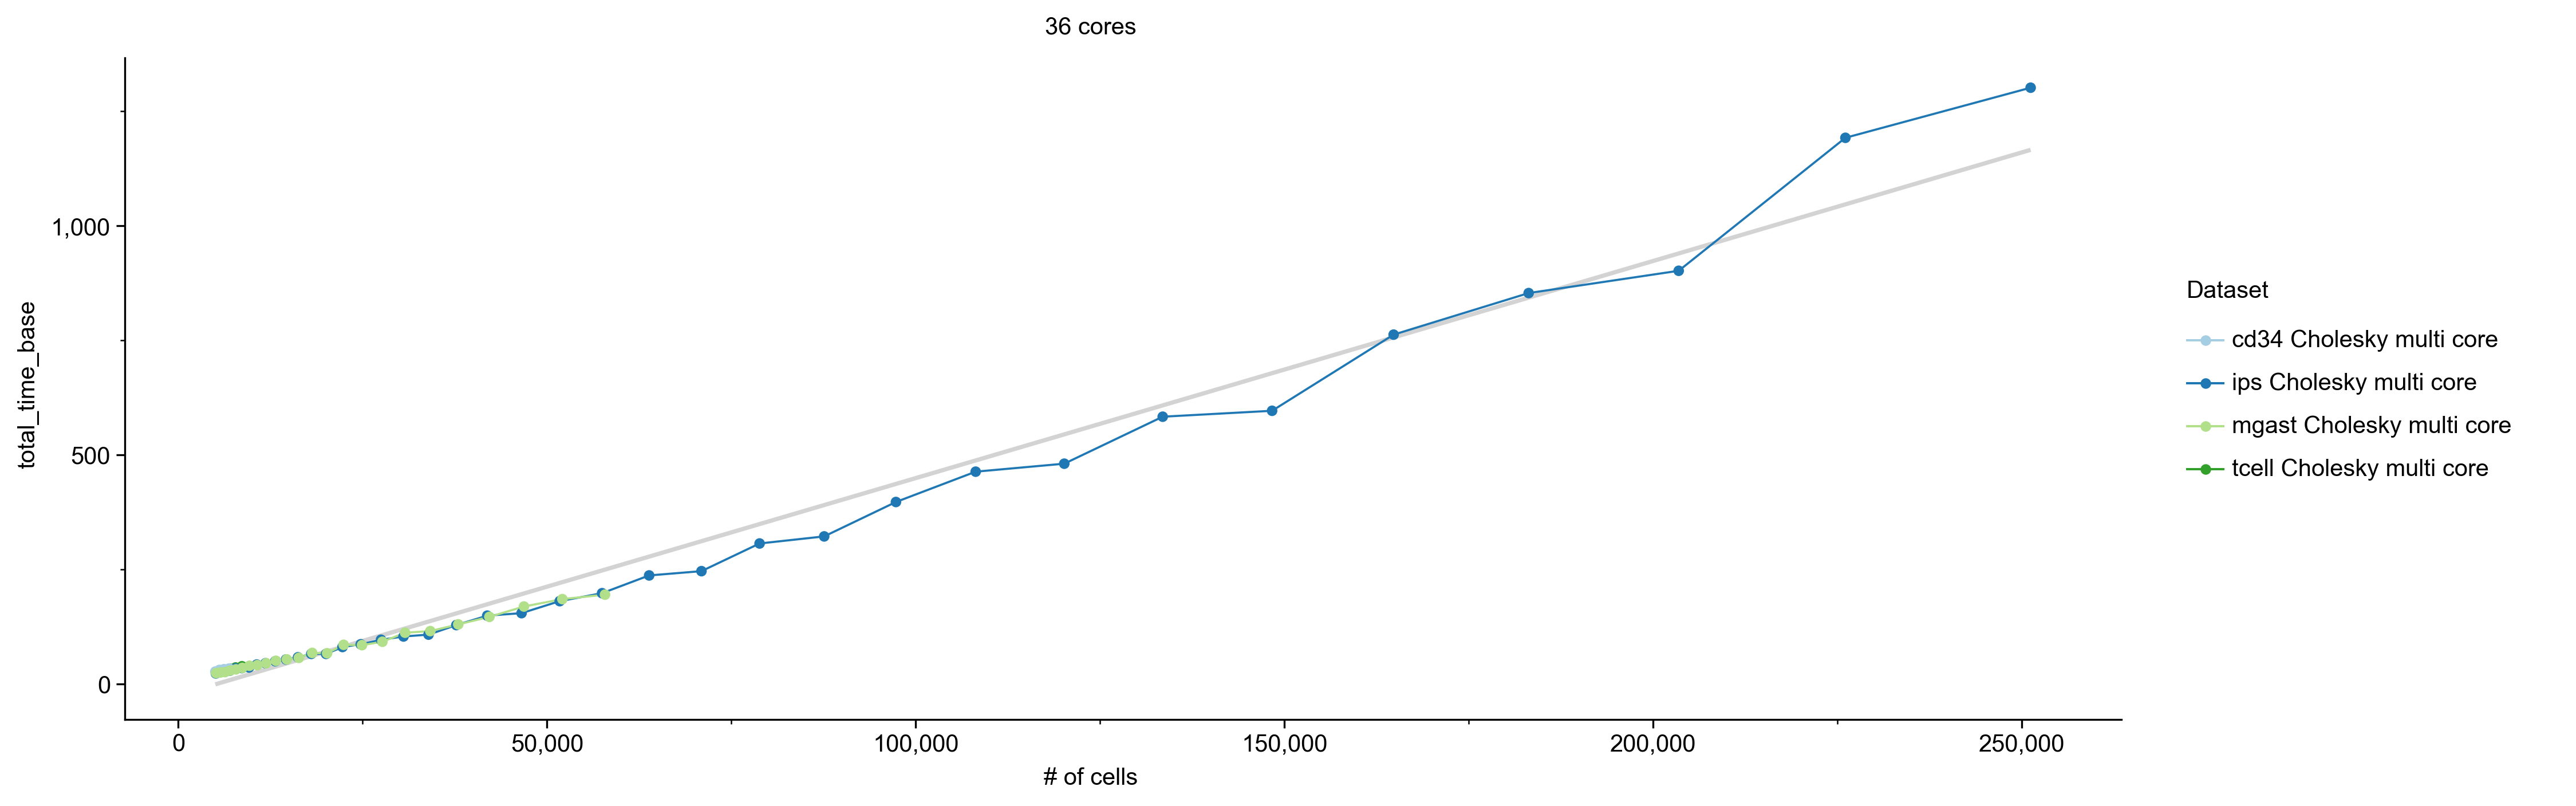

In [28]:
jump = 5000
idx = (stats["n_obs"] > jump) & ((stats["cores"] == 36)) & ((~stats["nystrom"])) & ((~stats["fractal"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time_base", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time_base"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"36 cores")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

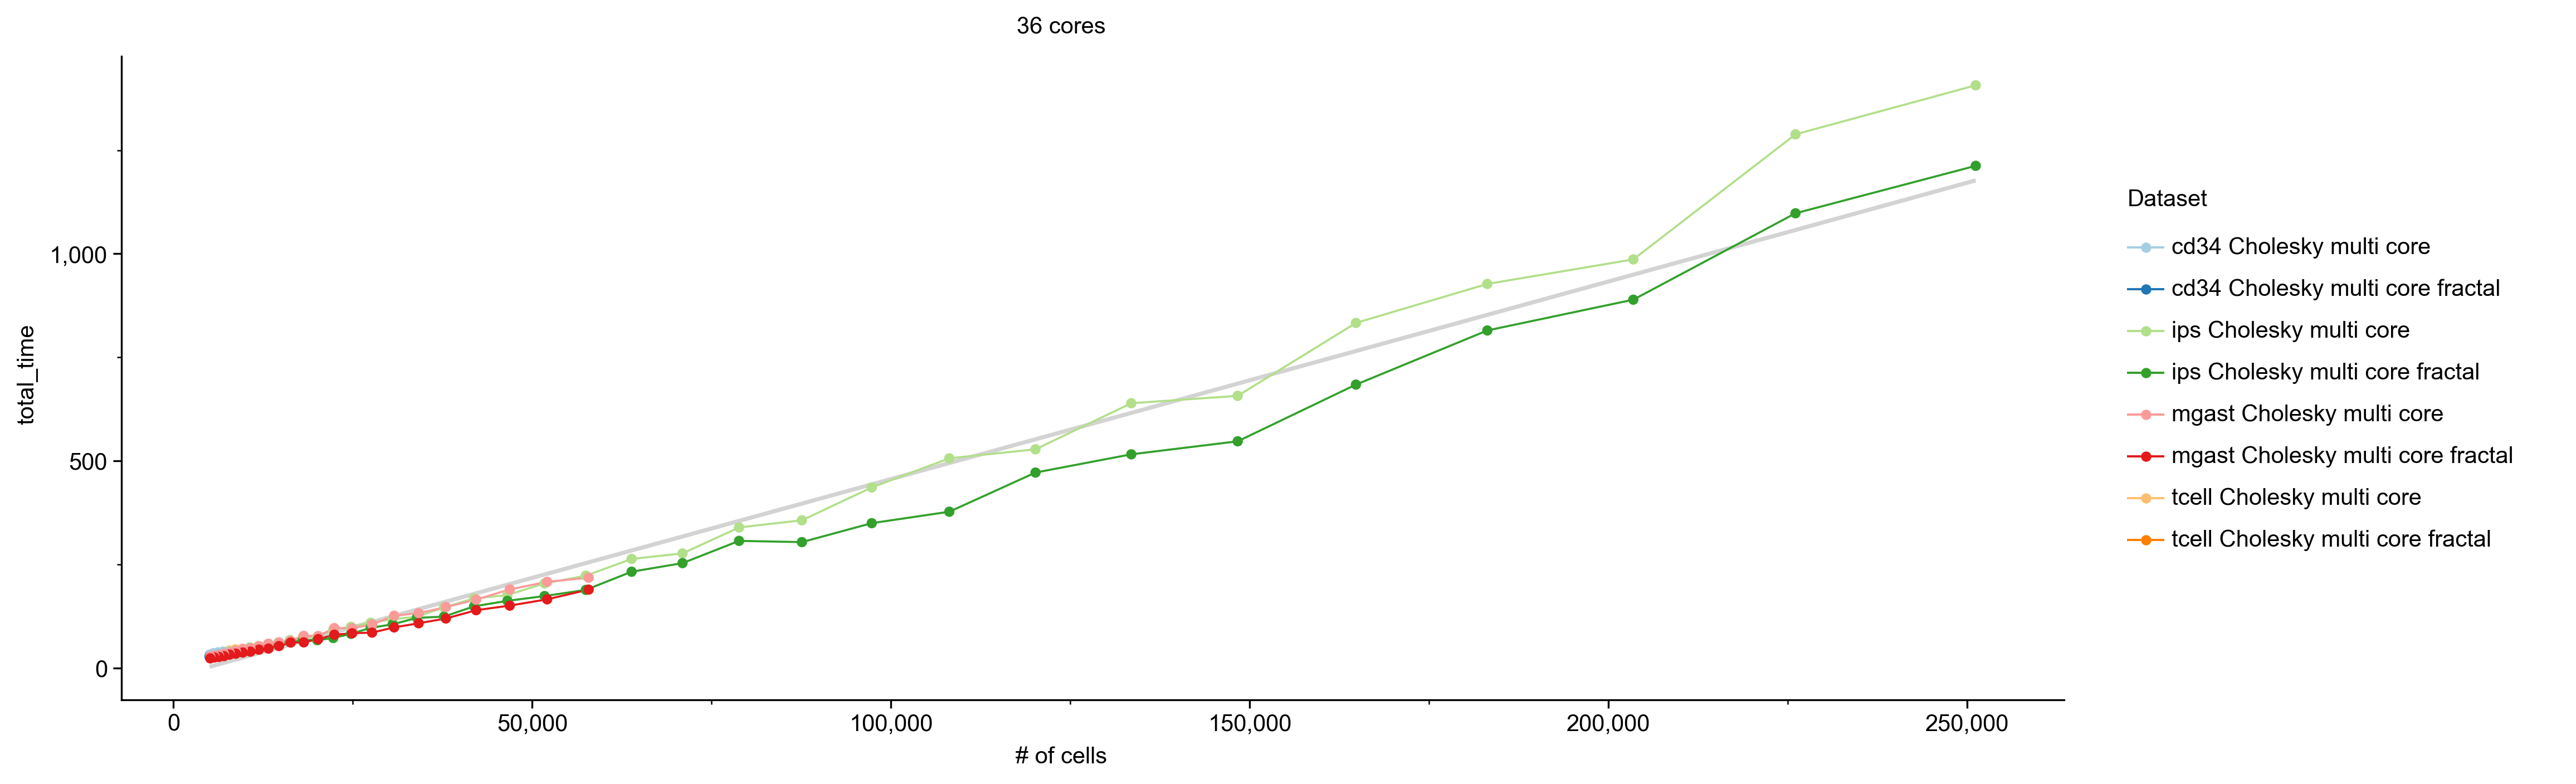

In [29]:
jump = 5000
idx = (stats["n_obs"] > jump) & ((stats["cores"] == 36)) & ((~stats["nystrom"]))
sub_stats = stats.loc[idx, :].copy()
sub_stats["desc"] = sub_stats["desc"].astype("str")
pl = (
    p9.ggplot(sub_stats, p9.aes("n_obs", "total_time", color="desc", group="desc"))
    + p9.geom_smooth(
        p9.aes("n_obs", "total_time"), method="lm", formula="y~x", inherit_aes=False, color="lightgrey", alpha=0
    )
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10() + p9.scale_x_log10()
    # + p9.geom_vline(xintercept=5000, alpha=.3)
    # + p9.geom_vline(xintercept=20000, alpha=.3)
    + p9.ggtitle(f"36 cores")
    + p9.xlab("# of cells")
    + p9.labs(color = "Dataset")
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.scale_x_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
    + p9.scale_y_continuous(labels = lambda x: [f"{int(n):,}" for n in x])
)
print(pl)

In [30]:
import pwd
user_info = pwd.getpwuid(os.getuid())
author = user_info.pw_gecos
email = user_info.pw_name + "@fredhutch.org"
%load_ext watermark
%watermark -a "{author}" -e {email} -h -v -iv -m -u -w -i

Author: Dominik Otto, S2-106, x4475,umask=0007, Setty Lab,

Email: dotto@fredhutch.org

Last updated: 2023-06-22T21:26:38.823596-07:00

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.13.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 4.15.0-192-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 36
Architecture: 64bit

Hostname: gizmok125

sys       : 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
pandas    : 1.5.3
matplotlib: 3.7.1
re        : 2.2.1
plotnine  : 0.10.1
numpy     : 1.24.3

Watermark: 2.3.1

